# ValueInvestor
We are looking to establish a robust intelligent system that can aid investment activities, using past stock performance data. 

Our goal in this project is to use provided historical trading data to predict future stock price valuations on a daily, weekly, and monthly basis. We also provide recommendations on whether to BUY, HOLD or SELL each stock based on the predictions.

### Data Description


We are given trading data from 8 different countries in emerging markets that include the 2020 Q1-Q2-Q3-Q4 and 2021 Q1 stock prices. Each market's operating days varies based on the country of the company and the market the stocks are exchanged. We will only 2020 data and predict with 2021 Q1 data.

Each set of data contain the following columns:
- `Date`
- `Price` (The closing price of the stock on a day)
- `Open` (The opening price of the stock on a day)
- `High` (The highest price of the stock on a day)
- `Low` (The lowest price of the stock on a day)
- `Vol.` (The volume/number of shares that were traded on a day)
- `Change %` (The percentage change from the closing price of the previous day)

### Data Loading
Let's first load the data of the first sheet.

In [825]:
# Import the necessary packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
import plotly.express as px
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
import warnings
import math

In [255]:
df = pd.read_excel("2020Q1Q2Q3Q4-2021Q1.xlsx", sheet_name=None)

In [256]:
print(df.keys())

dict_keys(['Russia - Sberbank Rossii PAO (S', 'Turkey - Koc Holding AS (KCHOL)', 'Egypt - Medinet Nasr Housing (M', 'Brazil - Minerva SABrazil (BEEF', 'Argentina - Pampa Energia SA (P', 'Colombia - Cementos Argos SA (C', 'South Africa - Impala Platinum ', 'South Korea - Dongkuk Steel Mil'])


In [257]:
sheet1 = df[list(df.keys())[0]] # Extract the first sheet
sheet1 = sheet1.iloc[:-1,:] # Drop the last row
sheet1["Price"].describe(percentiles=[0.25, 0.5, 0.75])

count     311.0
unique    303.0
top       272.0
freq        2.0
Name: Price, dtype: float64

In [258]:
sheet1["Price"].astype(float).describe()

count    311.000000
mean     234.524019
std       32.079847
min      174.270000
25%      207.700000
50%      229.140000
75%      264.380000
max      293.300000
Name: Price, dtype: float64

In [259]:
sheet1["Change %"].describe()

count    311.000000
mean       0.000668
std        0.021931
min       -0.095700
25%       -0.010100
50%        0.000400
75%        0.012950
max        0.129000
Name: Change %, dtype: float64

### Data Exploration

#### Check for missing values

In [260]:
sheet1.isnull().sum()

Date        0
Price       0
Open        0
High        0
Low         0
Vol.        0
Change %    0
dtype: int64

#### Check for outliers

In [261]:
fig = px.box(sheet1, x="Price")
fig.show()

In [262]:
fig = px.box(sheet1, x="Open")
fig.show()

In [263]:
fig = px.box(sheet1, x="High")
fig.show()

In [264]:
fig = px.box(sheet1, x="Low")
fig.show()

In [265]:
sheet1['Vol.'].str[:-1].astype(float)

0      47.00
1      38.81
2      43.68
3      56.07
4      35.22
       ...  
306    18.85
307    38.33
308    40.82
309    22.35
310    35.85
Name: Vol., Length: 311, dtype: float64

In [266]:
sheet1['Vol.'] = sheet1['Vol.'].str[:-1].astype(float)
fig = px.box(sheet1, x='Vol.')
fig.show()

/var/folders/jh/j6vtvp7j173g61vmlpt86gyh0000gn/T/ipykernel_89951/3553842436.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [267]:
sheet1['Vol.'].describe()

count    311.000000
mean      73.056977
std       38.058095
min        8.760000
25%       47.670000
50%       66.260000
75%       85.120000
max      263.040000
Name: Vol., dtype: float64

In [268]:
fig = px.box(sheet1, x="Change %")
fig.show()

In [269]:
sheet1['Change %'].describe()

count    311.000000
mean       0.000668
std        0.021931
min       -0.095700
25%       -0.010100
50%        0.000400
75%        0.012950
max        0.129000
Name: Change %, dtype: float64

Now we will plot the price over time.

In [270]:
# Convert dates to DateTime
sheet1["Datetime"] = pd.to_datetime(sheet1["Date"],format='%Y-%m-%d %H:%M:%S') 

# Set Datetime as the index
sheet1 = sheet1.set_index(pd.DatetimeIndex(sheet1["Datetime"])).sort_index()

/var/folders/jh/j6vtvp7j173g61vmlpt86gyh0000gn/T/ipykernel_89951/3080680778.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [271]:
fig = px.line(sheet1, x='Datetime', y="Price")
fig.show()

### ARIMA (Autoregressive integrated moving average)

#### Check assumptions of the ARIMA model
The following assumptions need to be satisified:
- Data should be stationary
- Data should be univariate

To check that the data is stationary, we can use the ADF (Augmented Dickey-Fuller) Test.

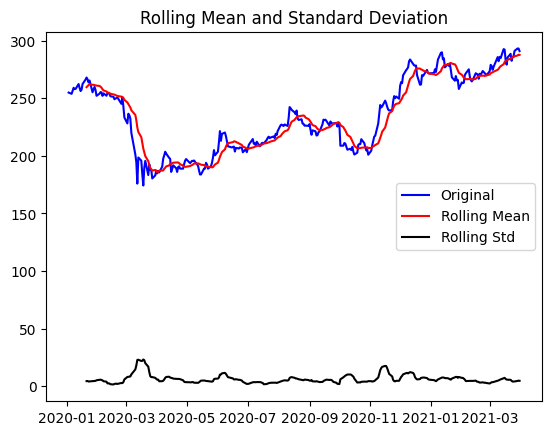

Results of dickey fuller test
Test Statistics                 -0.986360
p-value                          0.758207
No. of lags used                 8.000000
Number of observations used    302.000000
critical value (1%)             -3.452190
critical value (5%)             -2.871158
critical value (10%)            -2.571895
dtype: float64


In [272]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
test_stationarity(sheet1.Price)

As the p-value > 0.05, we can't rule out the null hypothesis that a unit root exists in this sample.

<Figure size 640x480 with 0 Axes>

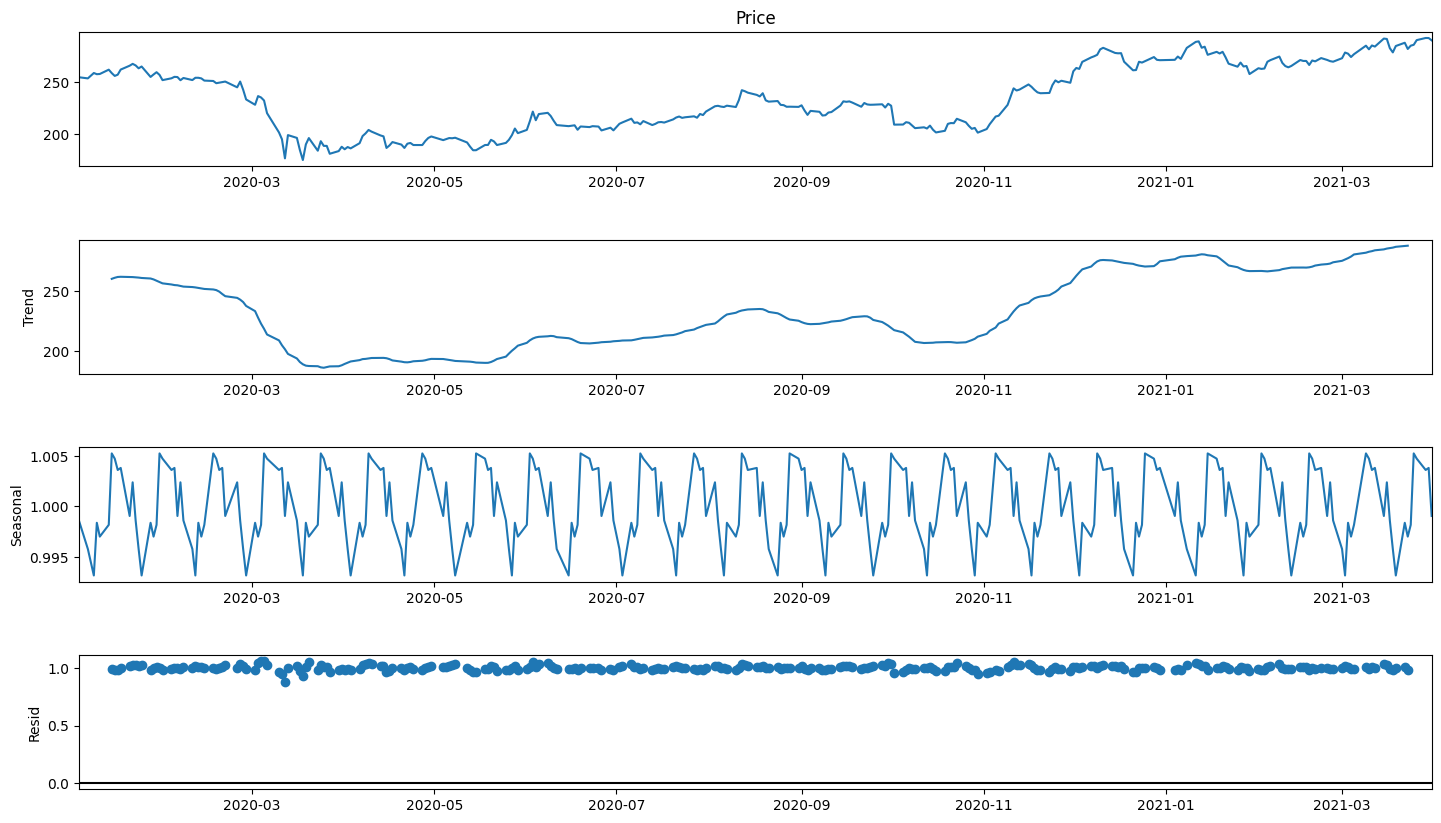

In [273]:
# Separate the trend and the seasonality from a time series
result = seasonal_decompose(sheet1.Price, period=12, model='multiplicative')
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

We can try and normalize the seasonality by the difference of log to price and shifted the log value of price to one step.

<AxesSubplot: title={'center': 'after log transformed & differencing'}, xlabel='Datetime'>

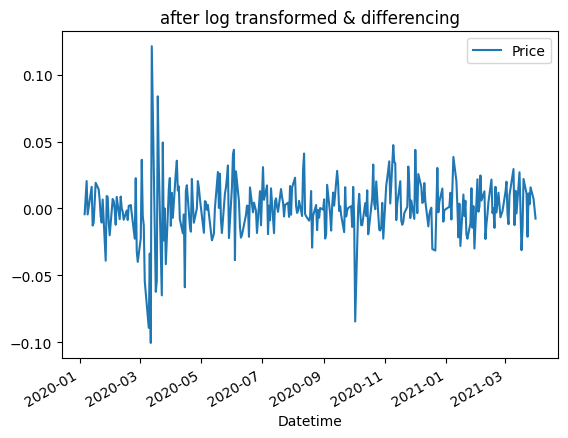

In [274]:
log_prices = pd.DataFrame(sheet1.Price.apply(lambda x : np.log(x)))
log_diff = log_prices - log_prices.shift()
#ax1 = plt.subplot()
log_diff.plot(title='after log transformed & differencing')
#ax2 = plt.subplot()
#sheet1.Price.plot(title='original'); 

Try the test for stationarity again.

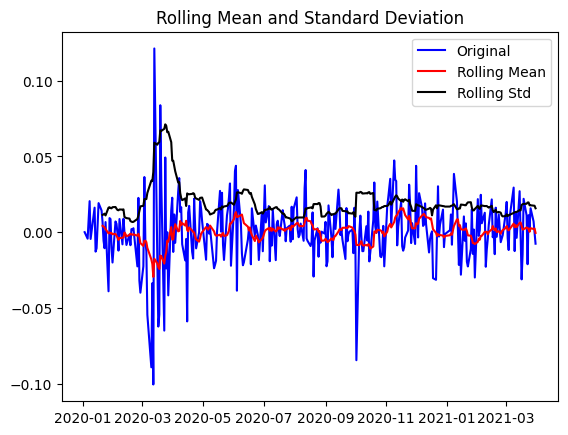

Results of dickey fuller test
Test Statistics               -5.905231e+00
p-value                        2.718502e-07
No. of lags used               7.000000e+00
Number of observations used    3.030000e+02
critical value (1%)           -3.452118e+00
critical value (5%)           -2.871127e+00
critical value (10%)          -2.571878e+00
dtype: float64


In [275]:
test_stationarity(log_diff.fillna(0))

Now the p-value is < 0.05.

Now lets split the data into training and testing data.
- We'll use data from 2020-01-01 to 2020-09-30 for training the model
- We'll use data from 2020-10-01 to 2020-12-31 for testing the model

In [276]:
train_data = log_diff[log_diff.index < datetime.strptime("2021-01-01", "%Y-%m-%d")]
test_data = log_diff[(log_diff.index >= datetime.strptime("2020-10-01", "%Y-%m-%d")) & (log_diff.index < datetime.strptime("2021-01-01", "%Y-%m-%d"))]

In [277]:
train_data = sheet1[sheet1["Datetime"] < datetime.strptime("2020-10-01", "%Y-%m-%d")]
test_data = sheet1[(sheet1["Datetime"] >= datetime.strptime("2020-10-01", "%Y-%m-%d")) & (sheet1["Datetime"] < datetime.strptime("2021-01-01", "%Y-%m-%d"))]

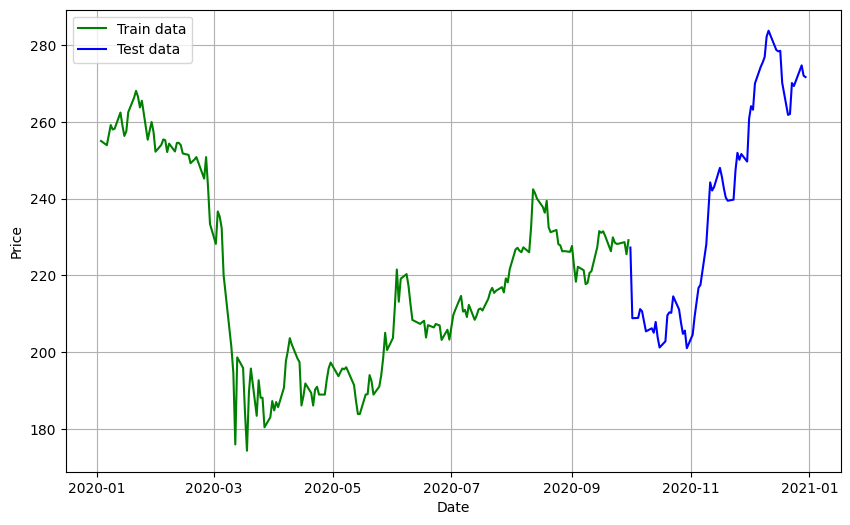

In [278]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Price')
plt.plot(train_data["Datetime"], train_data["Price"], 'green', label='Train data')
plt.plot(test_data["Datetime"], test_data["Price"], 'blue', label='Test data')
plt.legend()

Using Auto ARIMA, we'll now choose the p, d and q values for our model, where:
- `p`: The auto-regressive part
- `d`: The integrated/differencing part - the amount of past time points to subtract from the current value
- `q`: The moving average part

/Users/shamil/workspace/ValueInvestor/.venv/lib/python3.10/site-packages/pmdarima/arima/_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1117.175, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1119.022, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1119.000, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1115.325, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1121.174, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.122 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  186
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -556.663
Date:                Fri, 10 Feb 2023   AIC                           1115.325
Time:                        20:14:23   BIC                           1118.545
Sample:                             0   HQIC                          1116.630
                                - 186                                       

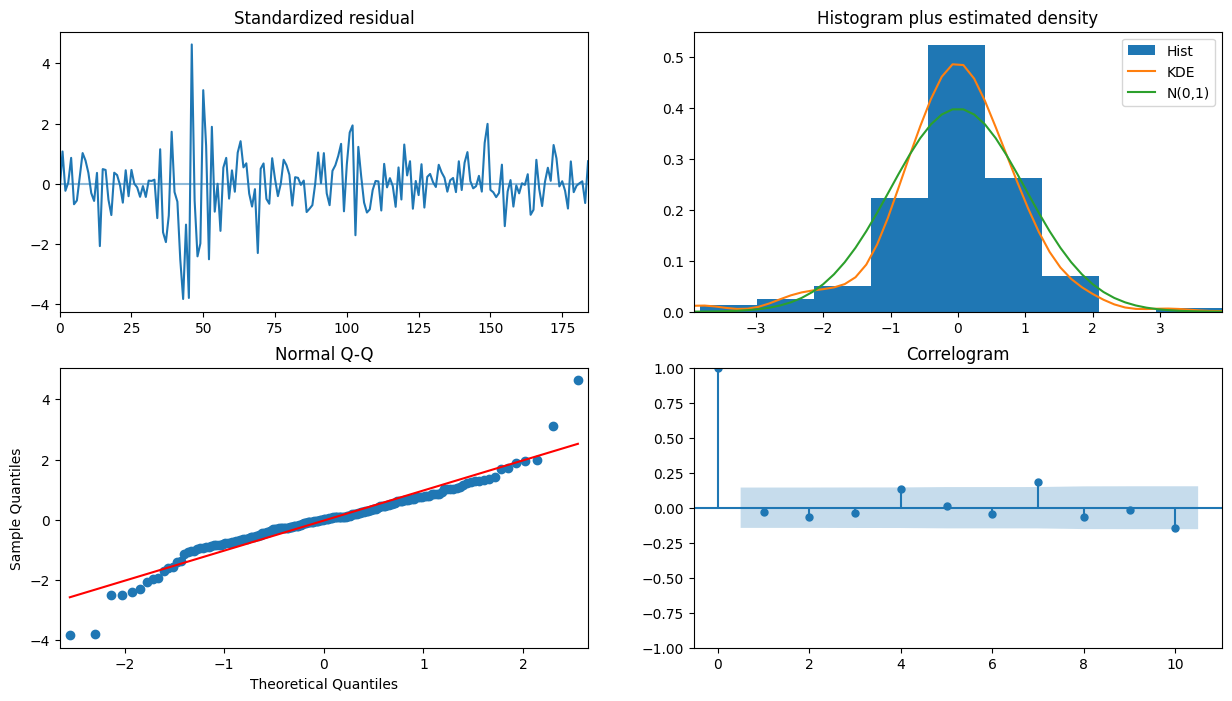

In [279]:
# Use Auto ARIMA to find the best p, d, and q values
model_autoARIMA = auto_arima(train_data.Price, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=6, max_q=6, # maximum p and q
                      m=12,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

We get the result, `Best model:  SARIMA(0,1,0)(0,0,0)[0]`, therefore the best parameters are p=0, d=1, q=0.

In [280]:
# Change train_data range
train_data = sheet1[sheet1["Datetime"] < datetime.strptime("2021-01-01", "%Y-%m-%d")]

In [281]:
# Build Model
#model = ARIMA(train_data.resample("D").last().Price, order=model_autoARIMA.order)
model = ARIMA(train_data.resample("D").last().Price, order=[0,1,0])
fitted = model.fit()  
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                  363
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -756.924
Date:                Fri, 10 Feb 2023   AIC                           1515.847
Time:                        20:14:24   BIC                           1519.739
Sample:                    01-03-2020   HQIC                          1517.394
                         - 12-30-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        19.9952      0.982     20.368      0.000      18.071      21.919
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1000.99
Prob(Q):                              0.95   Pr

Let's do the same but with the SARIMAX model.

In [282]:
model_autoARIMA.order+(14,)

(0, 1, 0, 14)

In [283]:
import statsmodels.api as sm

model = sm.tsa.statespace.SARIMAX(train_data.resample("D").last().Price, order=model_autoARIMA.order, seasonal_order=model_autoARIMA.order+(12,))
fitted_sarimax = model.fit()
print(fitted_sarimax.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.59838D+00    |proj g|=  3.13513D-01

At iterate    5    f=  2.36266D+00    |proj g|=  7.84240D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      7      8      1     0     0   3.704D-07   2.363D+00
  F =   2.3626524882712663     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                                     SARIMAX Results                                      
Dep. Variable:                           

 This problem is unconstrained.


Lets also created models with the following p, d and q values:
- [0,1,1]
- [0,1,2]
- [1,1,1]

In [284]:
model = ARIMA(train_data.resample("D").last().Price, order=[0,1,1])
fitted2 = model.fit()  
print(fitted2.summary())

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                  363
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -755.534
Date:                Fri, 10 Feb 2023   AIC                           1515.067
Time:                        20:14:24   BIC                           1522.851
Sample:                    01-03-2020   HQIC                          1518.162
                         - 12-30-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1287      0.035     -3.705      0.000      -0.197      -0.061
sigma2        20.5150      1.086     18.883      0.000      18.386      22.644
Ljung-Box (L1) (Q):                   1.85   Jarque-

In [285]:
model = ARIMA(train_data.resample("D").last().Price, order=[0,1,2])
fitted3 = model.fit()  
print(fitted3.summary())

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                  363
Model:                 ARIMA(0, 1, 2)   Log Likelihood                -754.658
Date:                Fri, 10 Feb 2023   AIC                           1515.317
Time:                        20:14:24   BIC                           1526.991
Sample:                    01-03-2020   HQIC                          1519.958
                         - 12-30-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0706      0.050     -1.409      0.159      -0.169       0.028
ma.L2         -0.0987      0.076     -1.291      0.197      -0.249       0.051
sigma2        20.3015      1.068     19.013      0.0

In [286]:
model = ARIMA(train_data.resample("D").last().Price, order=[1,1,1])
fitted4 = model.fit()  
print(fitted4.summary())

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                  363
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -755.273
Date:                Fri, 10 Feb 2023   AIC                           1516.545
Time:                        20:14:24   BIC                           1528.220
Sample:                    01-03-2020   HQIC                          1521.186
                         - 12-30-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2219      0.530      0.419      0.675      -0.816       1.260
ma.L1         -0.3382      0.492     -0.688      0.492      -1.302       0.626
sigma2        20.4892      1.085     18.893      0.0

##### SES (Simple Exponential Smoothing) Model

In [287]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt

ses_model = SimpleExpSmoothing(np.asarray(train_data['Price']))

##### HES (Holt's Exponential Smoothing) Model

In [288]:
holt_model = Holt(np.asarray(train_data['Price']))

fit_holt = holt_model.fit(smoothing_level=.3, smoothing_trend=.05)

### Forecast on test dataset

##### ARIMA Model 1

In [289]:
predicted = fitted.get_prediction(start=pd.to_datetime("2020-10-01"), end=pd.to_datetime("2021-03-01"), dynamic=False, full_results=True)
predicted_ci = fitted.conf_int()
#predicted.predicted_mean

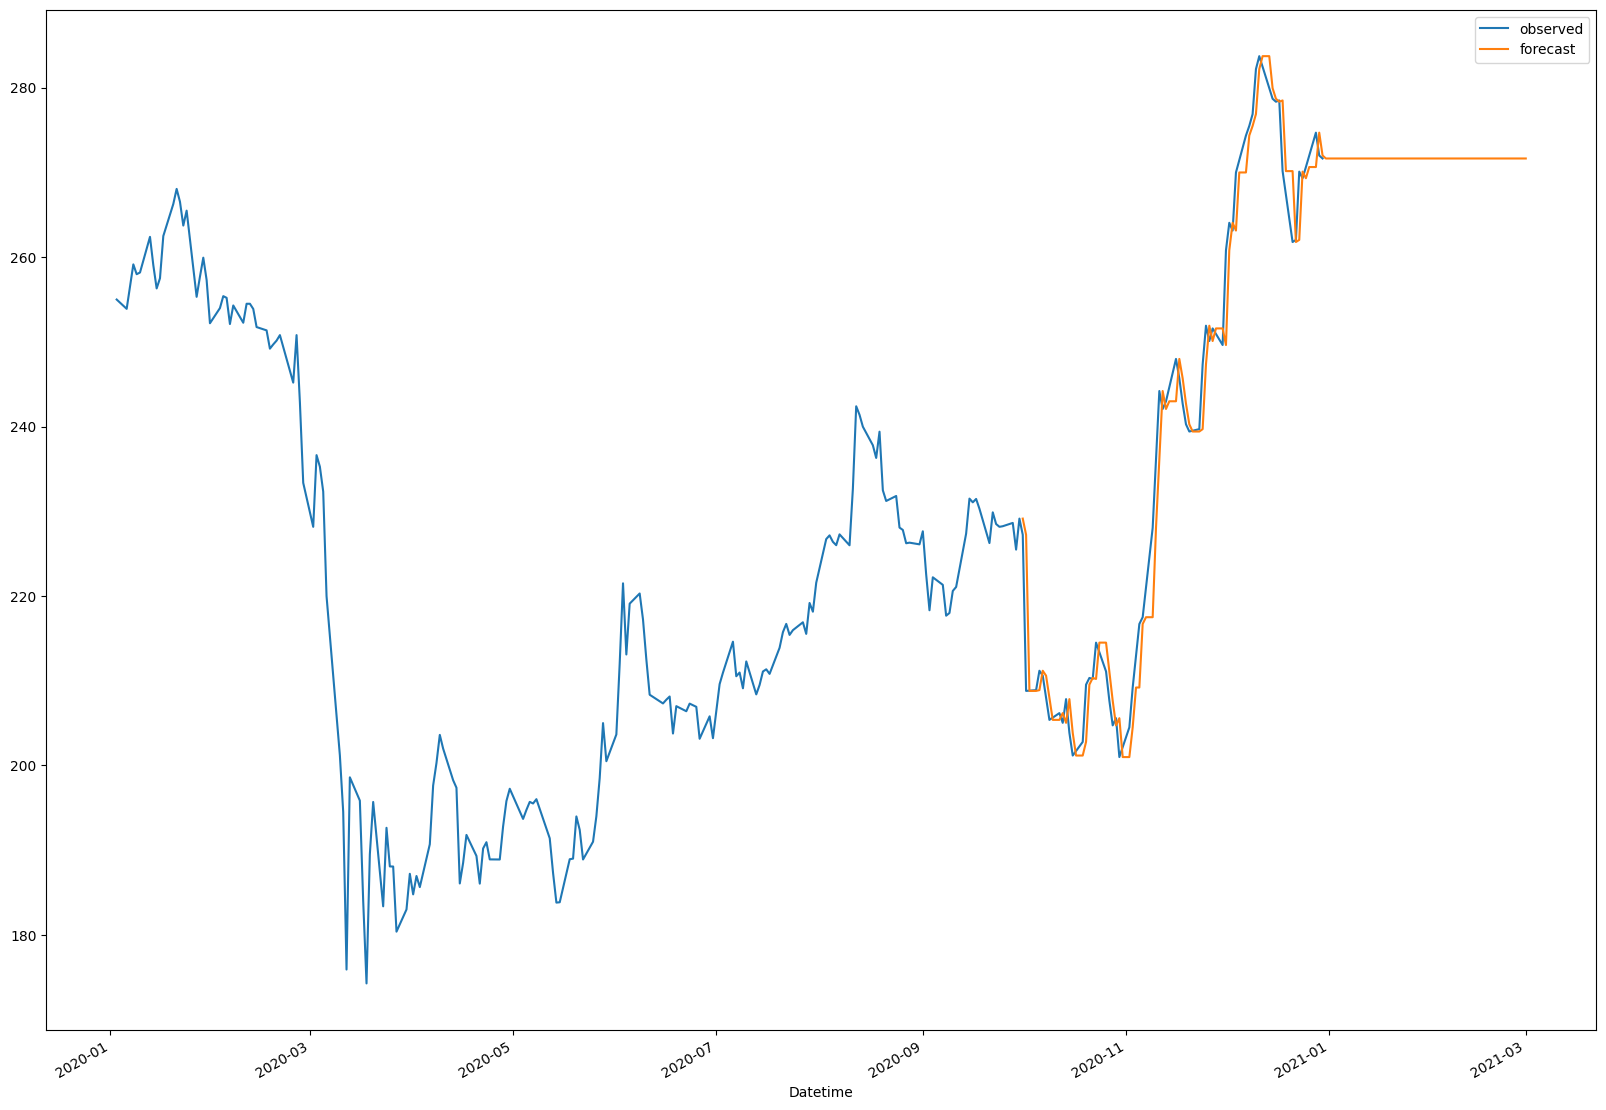

In [290]:
ax = (sheet1[sheet1["Datetime"] < datetime.strptime("2021-01-01", "%Y-%m-%d")].Price).plot(label='observed', figsize=(20, 15))
predicted.predicted_mean.plot(ax=ax, label='forecast')

#ax.fill_between(predicted_ci.index, predicted_ci.iloc[:, 0], predicted_ci.iloc[:, 1], color='k', alpha=.2)

plt.legend()
plt.show()

##### SARIMAX

In [291]:
predicted = fitted_sarimax.get_prediction(start=pd.to_datetime("2020-10-01"), end=pd.to_datetime("2021-04-01"), dynamic=False, full_results=True)
predicted_ci = fitted_sarimax.conf_int()

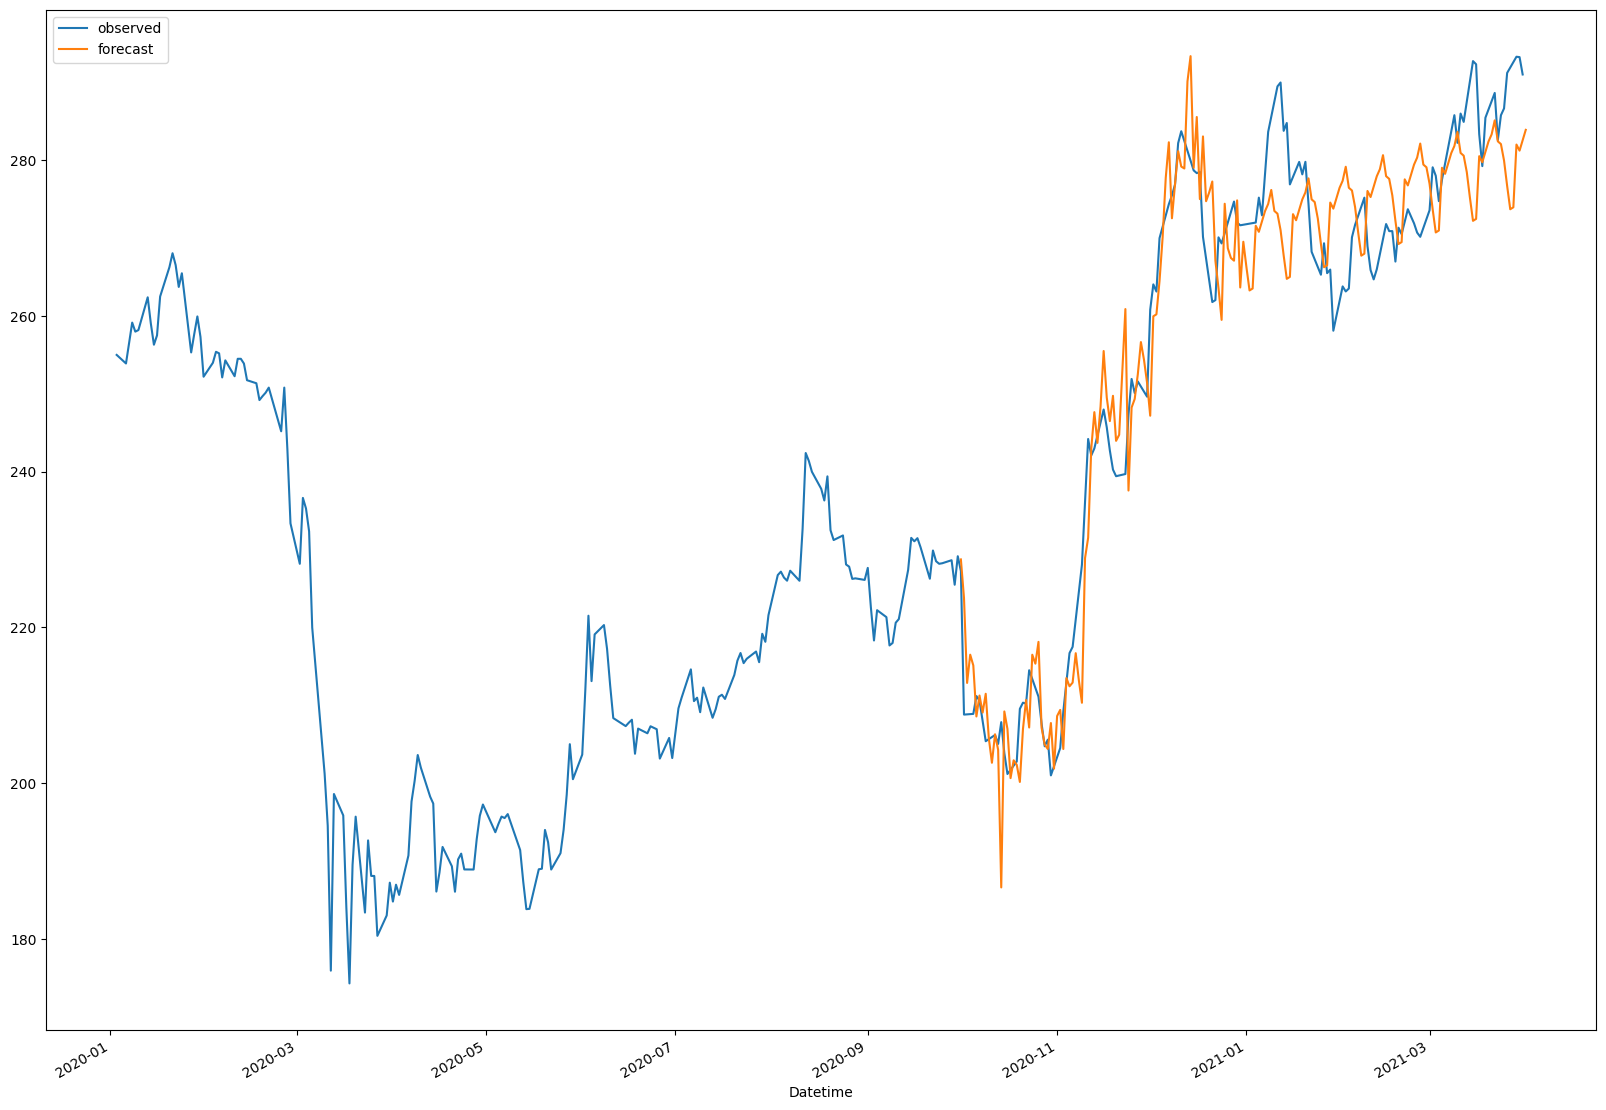

In [292]:
ax = (sheet1[sheet1["Datetime"] < datetime.strptime("2021-04-01", "%Y-%m-%d")].Price).plot(label='observed', figsize=(20, 15))
predicted.predicted_mean.plot(ax=ax, label='forecast')

plt.legend()
plt.show()

##### ARIMA Model 2

In [293]:
predicted = fitted2.get_prediction(start=pd.to_datetime("2020-10-01"), end=pd.to_datetime("2021-03-01"), dynamic=False, full_results=True)
predicted_ci = fitted2.conf_int()
#predicted.predicted_mean

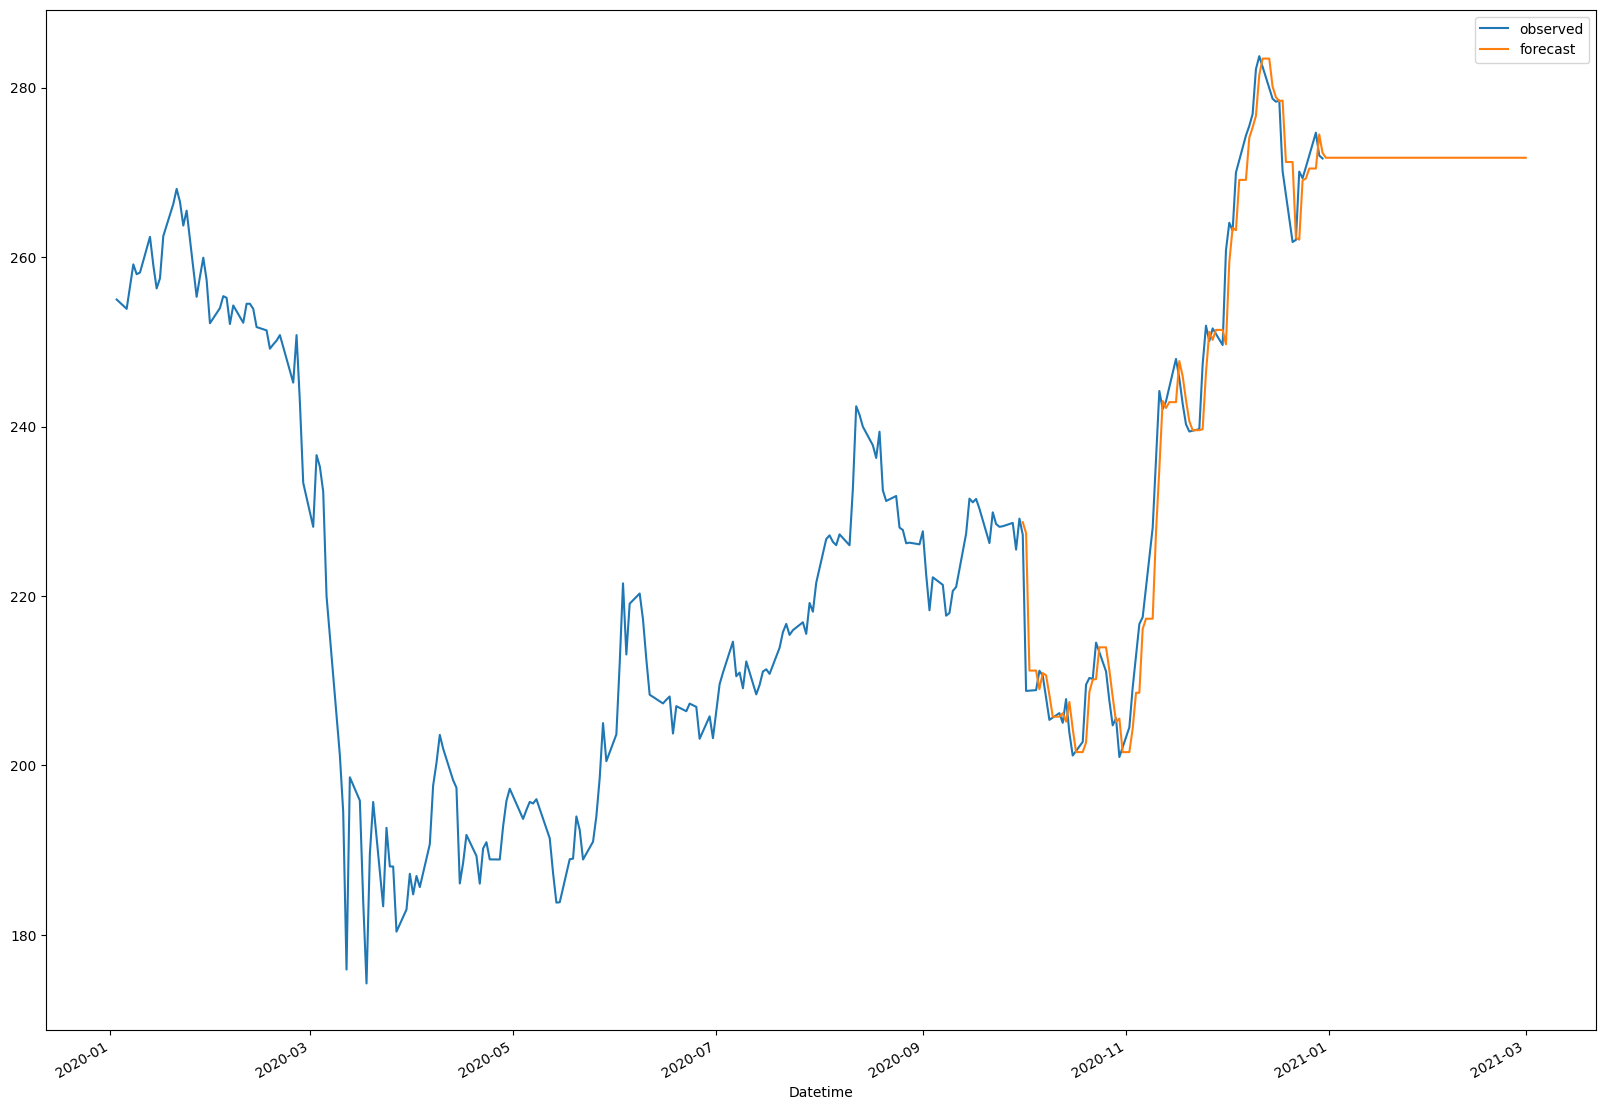

In [294]:
ax = (sheet1[sheet1["Datetime"] < datetime.strptime("2021-01-01", "%Y-%m-%d")].Price).plot(label='observed', figsize=(20, 15))
predicted.predicted_mean.plot(ax=ax, label='forecast')

#ax.fill_between(predicted_ci.index, predicted_ci.iloc[:, 0], predicted_ci.iloc[:, 1], color='k', alpha=.2)

plt.legend()
plt.show()

##### ARIMA Model 3

In [295]:
predicted = fitted3.get_prediction(start=pd.to_datetime("2020-10-01"), end=pd.to_datetime("2021-03-01"), dynamic=False, full_results=True)
predicted_ci = fitted3.conf_int()

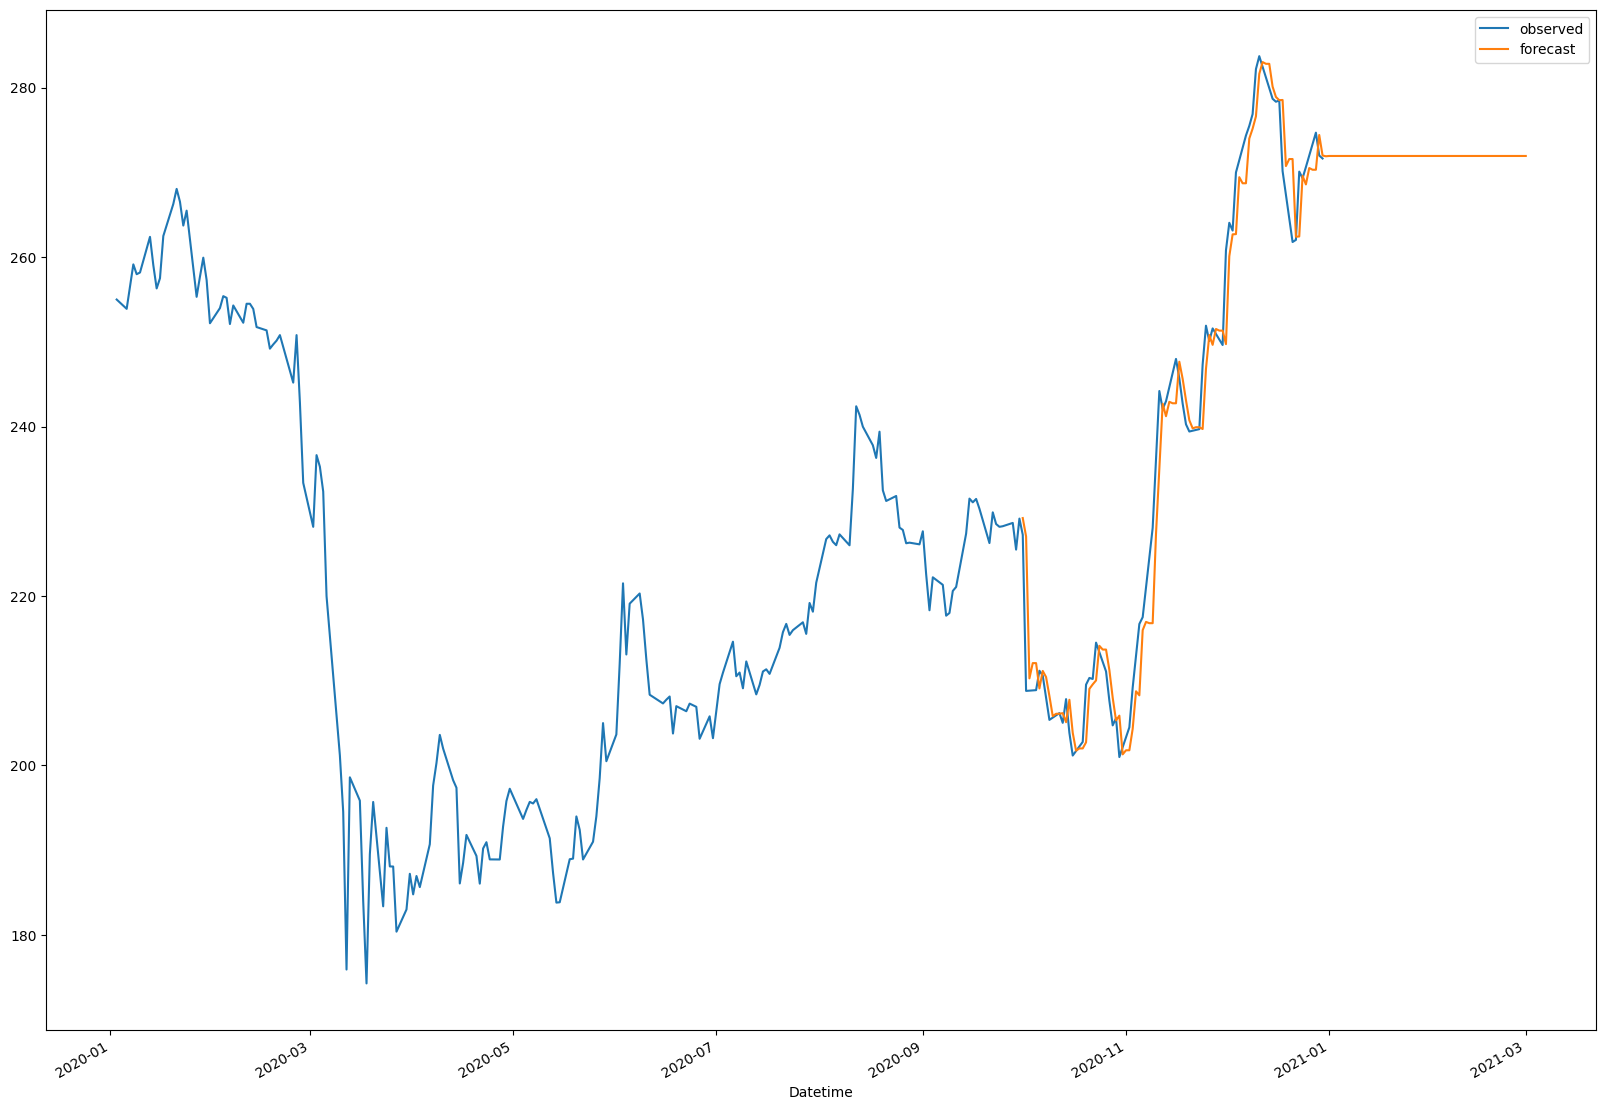

In [296]:
ax = (sheet1[sheet1["Datetime"] < datetime.strptime("2021-01-01", "%Y-%m-%d")].Price).plot(label='observed', figsize=(20, 15))
predicted.predicted_mean.plot(ax=ax, label='forecast')

#ax.fill_between(predicted_ci.index, predicted_ci.iloc[:, 0], predicted_ci.iloc[:, 1], color='k', alpha=.2)

plt.legend()
plt.show()

##### ARIMA Model 4

In [297]:
predicted = fitted4.get_prediction(start=pd.to_datetime("2020-10-01"), end=pd.to_datetime("2021-03-01"), dynamic=False, full_results=True)
predicted_ci = fitted4.conf_int()

In [298]:
predicted.predicted_mean[0:10]

2020-10-01    228.834531
2020-10-02    227.348701
2020-10-03    210.982599
2020-10-04    211.466932
2020-10-05    211.574408
2020-10-06    209.067380
2020-10-07    210.978013
2020-10-08    210.599035
2020-10-09    208.275346
2020-10-10    205.784338
Freq: D, Name: predicted_mean, dtype: float64

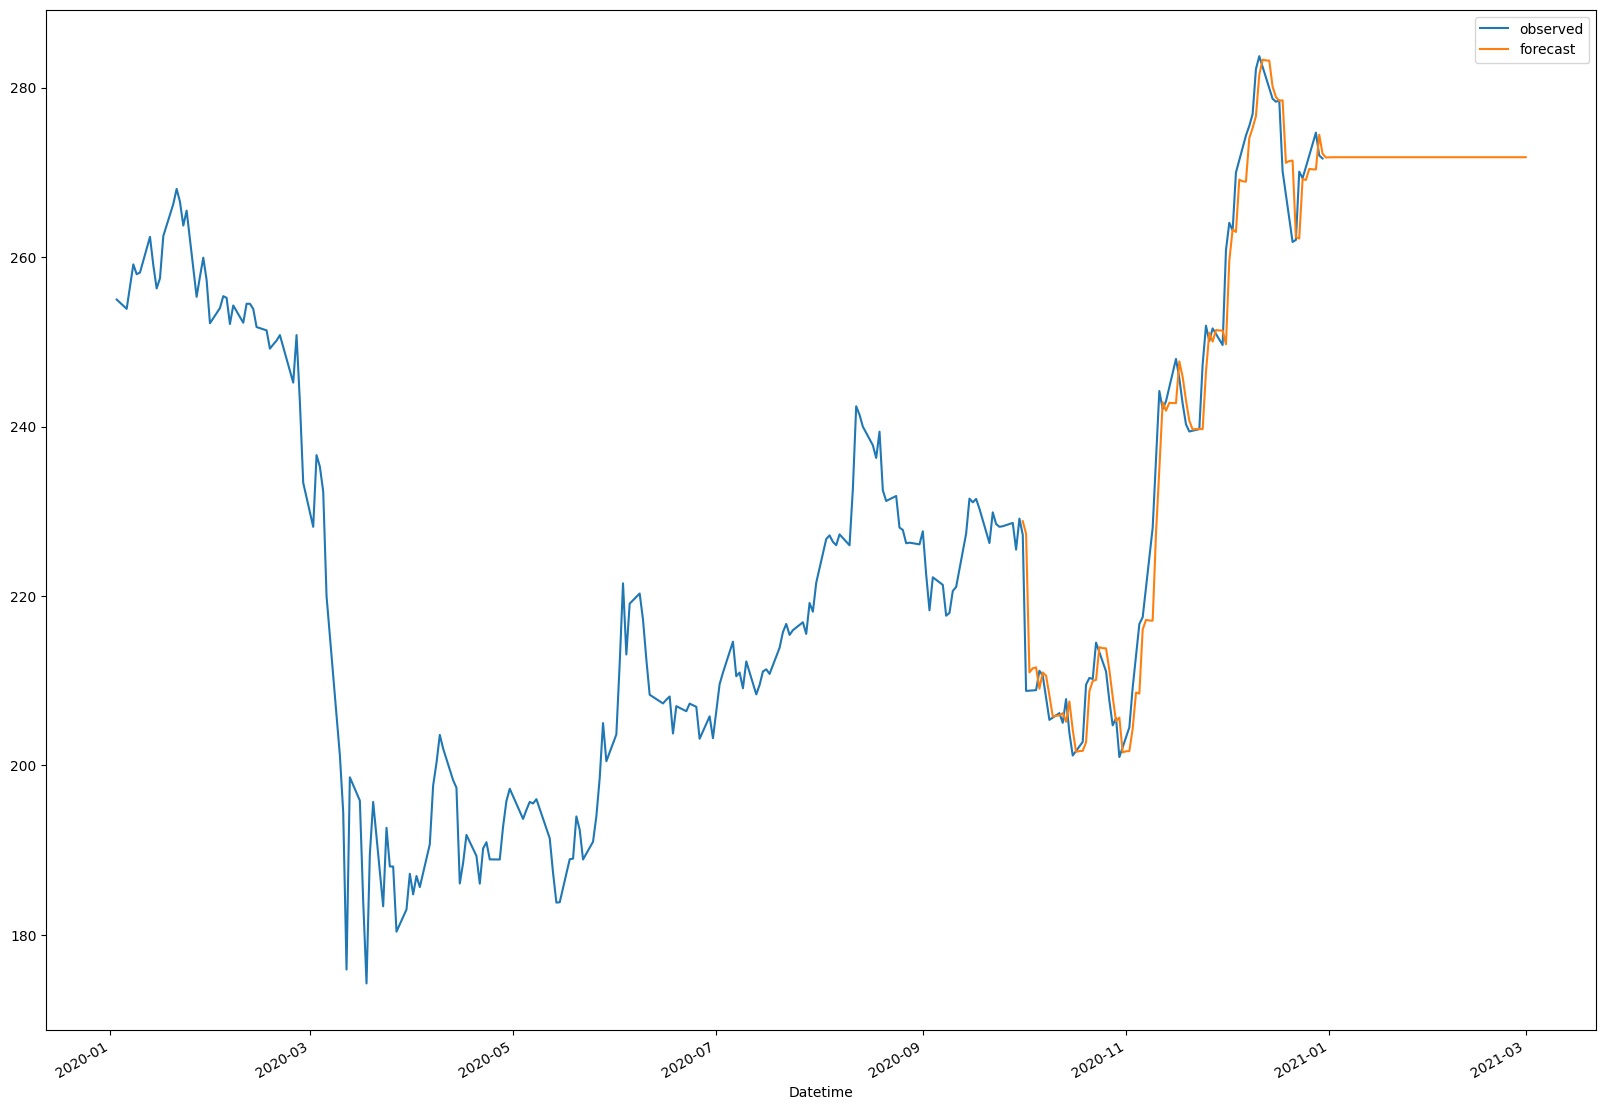

In [299]:
ax = (sheet1[sheet1["Datetime"] < datetime.strptime("2021-01-01", "%Y-%m-%d")].Price).plot(label='observed', figsize=(20, 15))
predicted.predicted_mean.plot(ax=ax, label='forecast')

#ax.fill_between(predicted_ci.index, predicted_ci.iloc[:, 0], predicted_ci.iloc[:, 1], color='k', alpha=.2)

plt.legend()
plt.show()

All of the ARIMA models have predictions that quickly (or immediately) converge to a single value.

##### SES (Simple Exponential Smoothing) Model

In [300]:
fit1 = ses_model.fit()
pred1 = fit1.forecast(9)
pred1

array([271.65000001, 271.65000001, 271.65000001, 271.65000001,
       271.65000001, 271.65000001, 271.65000001, 271.65000001,
       271.65000001])

With smoothing_level = 0.2

In [301]:
fit2 = ses_model.fit(smoothing_level=0.2)
pred2 = fit2.forecast(9)
pred2

array([271.33845345, 271.33845345, 271.33845345, 271.33845345,
       271.33845345, 271.33845345, 271.33845345, 271.33845345,
       271.33845345])

With smoothing_level = 0.5

In [302]:
fit3 = ses_model.fit(smoothing_level=0.5)
pred3 = fit3.forecast(9)
pred3

array([271.85594137, 271.85594137, 271.85594137, 271.85594137,
       271.85594137, 271.85594137, 271.85594137, 271.85594137,
       271.85594137])

Each of these models produce a constant value.

##### HES Model

In [303]:
#pred_holt = fit_holt.forecast(92)
pred_holt = fit_holt.forecast(152)

In [304]:
predictions_holt = pd.Series(pred_holt)
predictions_holt.index = predicted.predicted_mean.index

<AxesSubplot: xlabel='Datetime'>

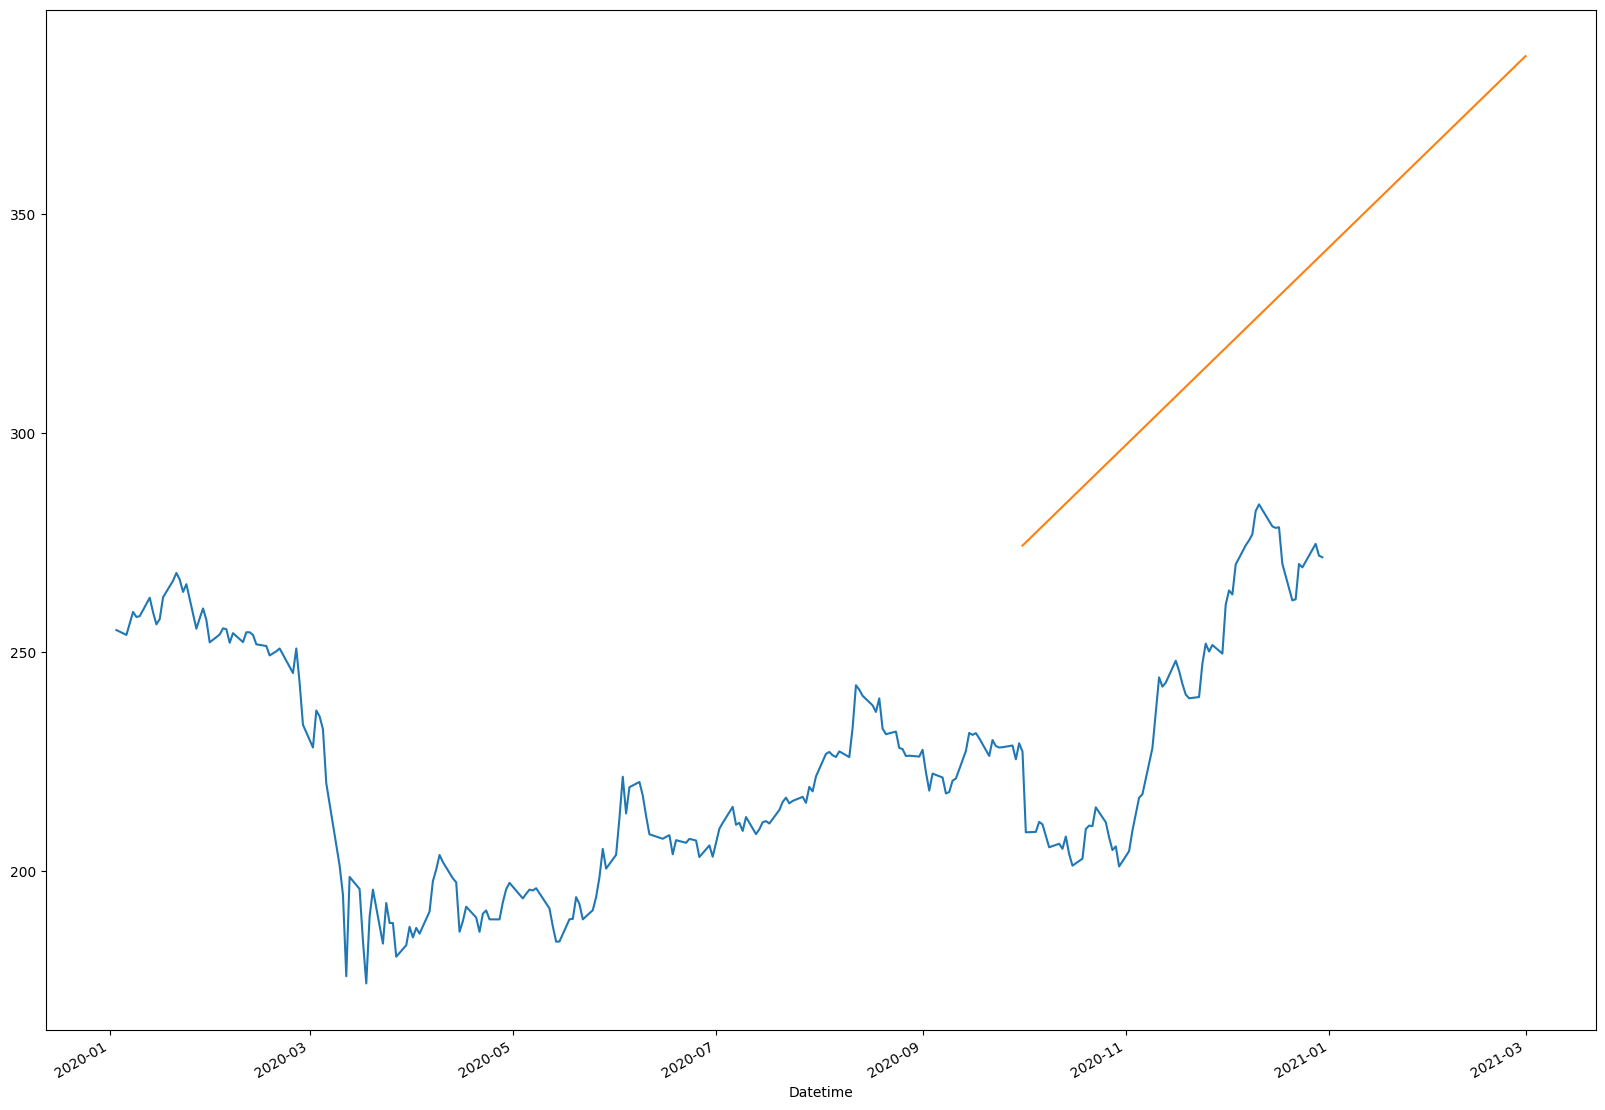

In [305]:
ax = (sheet1[sheet1["Datetime"] < datetime.strptime("2021-01-01", "%Y-%m-%d")].Price).plot(label='observed', figsize=(20, 15))
predictions_holt.plot(ax=ax, label='forecast')

##### Simple Moving Average Model

In [306]:
y_hat_sma = sheet1[sheet1["Datetime"] < datetime.strptime("2021-01-01", "%Y-%m-%d")].Price.copy()
ma_window = 90 # 3 months
y_hat_sma['Price'] = y_hat_sma.rolling(ma_window).mean()

(0.0, 289.20300000000003)

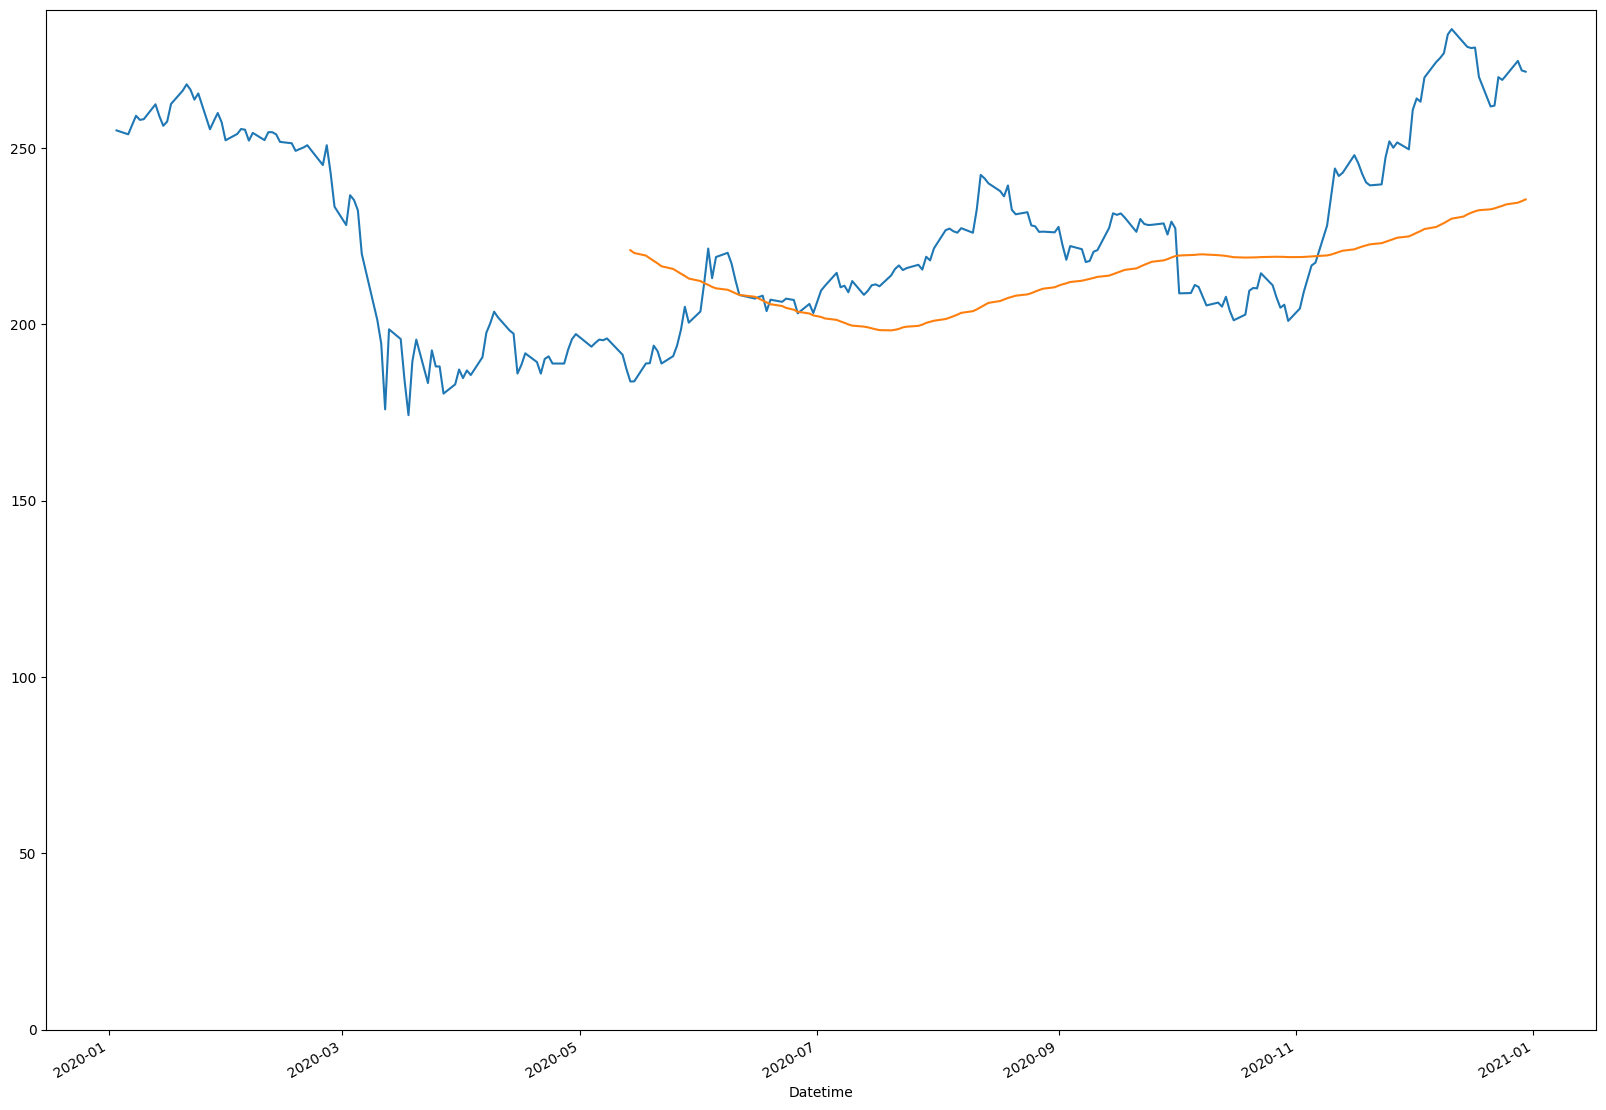

In [307]:
ax = (sheet1[sheet1["Datetime"] < datetime.strptime("2021-01-01", "%Y-%m-%d")].Price).plot(label='observed', figsize=(20, 15))
y_hat_sma.Price.plot(ax=ax, label='forecast')
ax.set_ylim(bottom=0)

### Forecast Future Unknown Data (2021 data)

Lets use the forecast from the SARIMAX model.

In [308]:
# TODO: SARIMAX predictions
predicted = fitted_sarimax.get_prediction(start=pd.to_datetime("2021-01-01"), end=pd.to_datetime("2021-04-01"), dynamic=False, full_results=True)
predicted_ci = fitted_sarimax.conf_int()

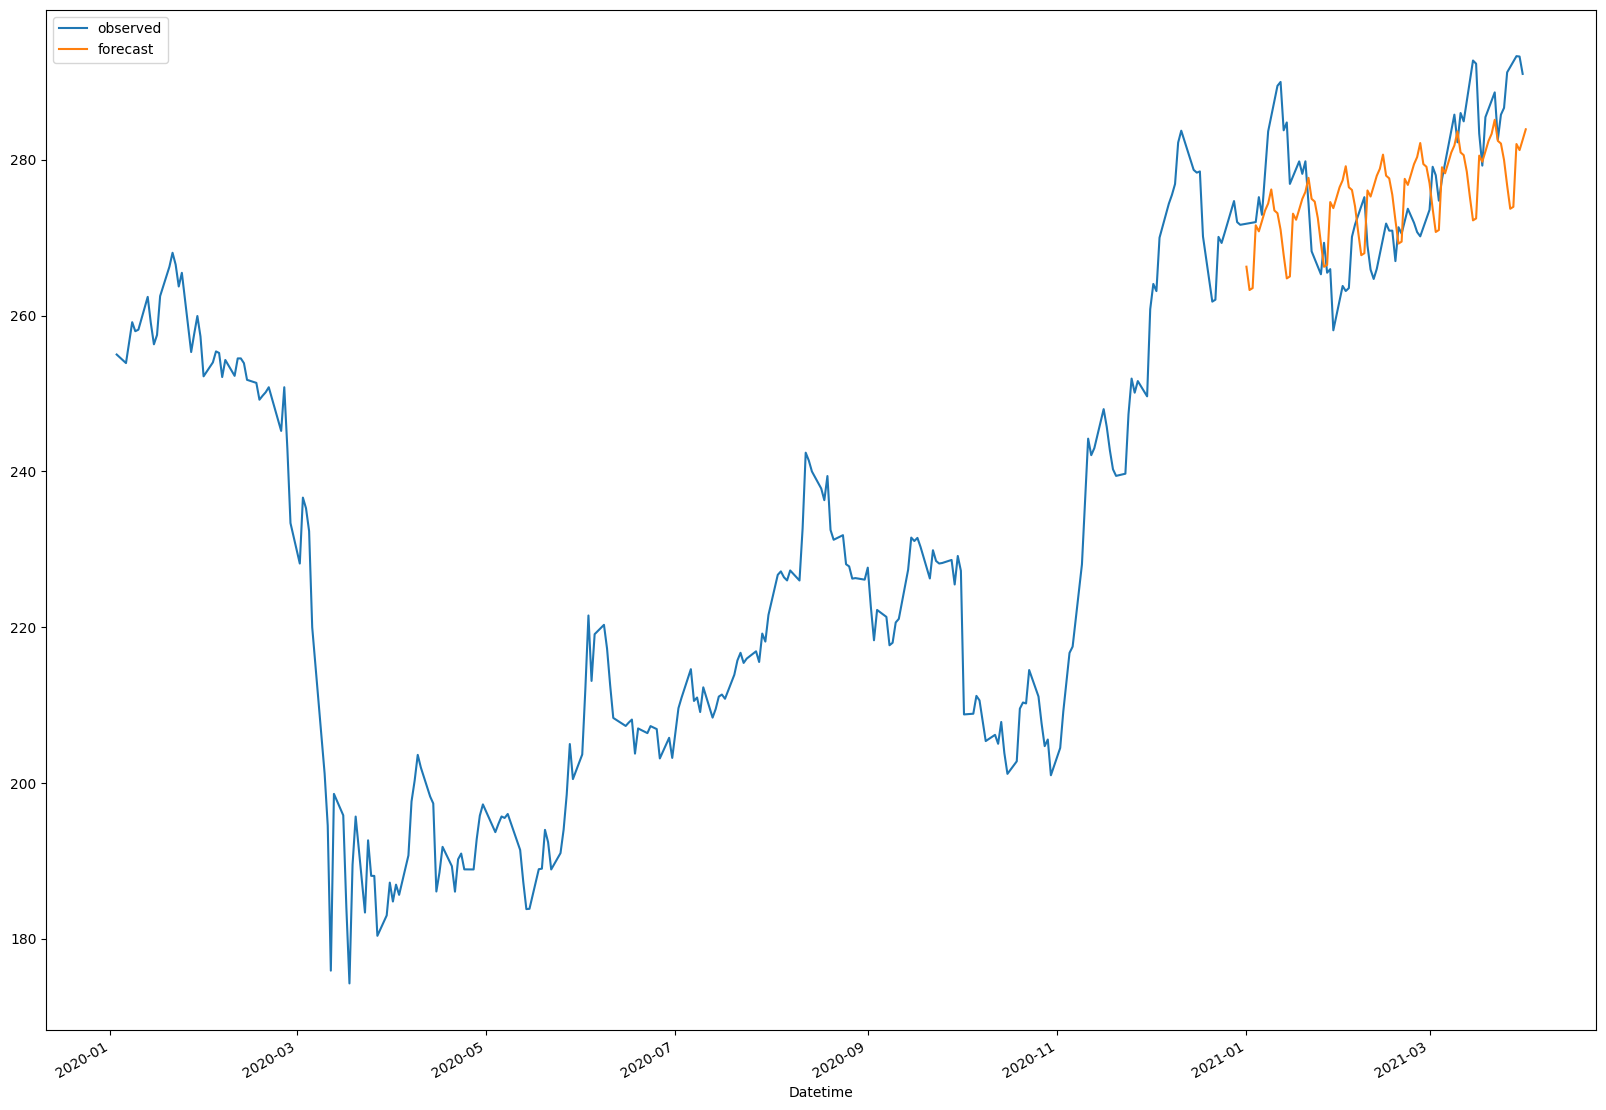

In [309]:
ax = (sheet1[sheet1["Datetime"] < datetime.strptime("2021-04-01", "%Y-%m-%d")].Price).plot(label='observed', figsize=(20, 15))
predicted.predicted_mean.plot(ax=ax, label='forecast')

plt.legend()
plt.show()

Lets add a column for the predicted price and the decision (to buy, sell or hold).

In [310]:
sheet1["Predicted Price"] = predicted.predicted_mean
sheet1["Decision"] = ""

Lets create a function to calculate the mean squared error between prices and predicted prices.

In [311]:
def calculate_error(df):
    return mean_squared_error(df["Price"], df["Predicted Price"])

In [312]:
# Calculate mse for SARIMAX model
print(f'MSE: {calculate_error(sheet1[sheet1.Datetime > "2020-12-31"])}')

# Calculate MAPE
print(f'MAPE: {mean_absolute_percentage_error(sheet1[sheet1.Datetime > "2020-12-31"]["Price"].to_numpy(), sheet1[sheet1.Datetime > "2020-12-31"]["Predicted Price"].to_numpy())}')

MSE: 85.25561848749015
MAPE: 0.026855297595330882


### Calculate Total Profit
Lets now create a function to calculate our total profit.

In [824]:
def calculate_profit(df, capital):
    starting_capital = capital
    num_stocks = 0
    
    for i in range(len(df.index)-1):
        current_decision = df.iloc[i].Decision

        # Perform calculation for BUY/SELL
        if current_decision == "BUY":
            num_stocks += math.trunc(capital/df.iloc[i].Price)
            capital -= math.trunc(capital/df.iloc[i].Price)*df.iloc[i].Price
        elif current_decision == "SELL":
            capital += num_stocks * df.iloc[i].Price
            num_stocks = 0
    
    if num_stocks == 0:
        return capital - starting_capital
    else:
        return num_stocks * df.iloc[i].Price - starting_capital + capital

### Strategy 1: Buy/sell/hold based on tomorrow's price

We will make decisions according to the following rules:
- If Predicted Price tomorrow > Price today => BUY
- If Predicted Price tomorrow > Price today AND Decision yesterday == BUY => HOLD
- If Predicted Price tomorrow < Price today => SELL

In [313]:
def make_decision(price_today, price_tomorrow, decision_yesterday):
    if float(price_tomorrow) > float(price_today):
        if "BUY" in decision_yesterday:
            return "HOLD"
        return "BUY"
    return "SELL"

Lets mark whether we should buy or sell on each day.

In [314]:
def hold_period_expired(df, i, hold_period):
    # Get last {hold_period} number of decisions
    decisions = set(df.iloc[i-hold_period:i, df.columns.get_loc('Decision')])
    # If a decision that is not HOLD exists, return false
    if decisions != set(["HOLD"]):
        return False
    return True

In [315]:
def make_decisions(df, hold_period):
    stocks_held = False

    for i in range(len(df.index)-1):
        if not hold_period_expired(df, i, hold_period):
            decision = "HOLD"
        else:
            # Compare today's price with yesterday's predicted price
            price_today = df.iloc[i]["Price"]
            price_tomorrow = df.iloc[i+1]["Predicted Price"]
            decision_yesterday = df.iloc[i-1]["Decision"]

            # Make decision
            decision = make_decision(price_today, price_tomorrow, decision_yesterday)

        if decision == "SELL" and not stocks_held:
            decision = "HOLD"

        if decision == "BUY":
            if stocks_held or not hold_period_expired(df, i, hold_period):
                decision = "HOLD"
            else:
                stocks_held = True
            
        df.at[df.iloc[i].Datetime, "Decision"] = str(decision)

        # Set first day decision to "BUY"
        if i==0:
            df.at[df.iloc[i].Datetime, "Decision"] = "BUY"
            stocks_held = True

    return df

### Strategy 2

In [316]:
# Buy and sell at local minima and maxima
def make_decisions_2(df):
    stocks_held = False

    for i in range(len(df.index)-1):
        # Compare today's price with yesterday's predicted price
        price_today = df.iloc[i]["Predicted Price"]
        price_tomorrow = df.iloc[i+1]["Predicted Price"]

        # Set first day decision to "BUY"
        if i==0:
            decision = "BUY"
            stocks_held = True
        else:
            if price_tomorrow > price_today:
                # Price is increasing tomorrow
                if not stocks_held:
                    decision = "BUY"
                    stocks_held = True
                else:
                    decision = "HOLD"
            elif price_tomorrow < price_today:
                # Price is decreasing tomorrow
                if stocks_held:
                    decision = "SELL"
                    stocks_held = False
                else:
                    decision = "HOLD"
            else:
                decision = "HOLD"
                
        df.at[df.iloc[i].Datetime, "Decision"] = str(decision)


        

    return df

In [317]:
sheet1_predictions_sarimax = make_decisions_2(sheet1[sheet1["Datetime"] > "2020-12-31"])

In [318]:
fig = px.line(predicted.predicted_mean)
fig.show()

### Strategy 3: Use prior data available
Here we look at the past 20 days's prices for the stock and make a decision based on the mean and standard deviation.

In [319]:
i=42
df_temp = sheet1[sheet1["Datetime"] > "2020-10-31"]
model = ARIMA(df_temp.iloc[i-20:i].resample("D").last()["Price"], order=[0,1,0])
fitted = model.fit()
predicted_price = fitted.get_prediction(start=df_temp.iloc[i]['Datetime'], end=df_temp.iloc[i]['Datetime']).predicted_mean
predicted_price[0]

271.65

In [320]:
def make_decisions_3(df, model_parameters=[0, 0, 0], arimax=False):
    stocks_held = False

    first_day_of_year = df.index.get_loc("2021-01-04")

    for i in range(first_day_of_year,len(df.index)):
        price = df.iloc[i]["Price"]

        # Create model and forecast next price
        #rolling_mean_volume = df.iloc[i-5:i]["Vol."].mean()
        train_exog = list(df.iloc[0:i-1]["Vol."].values)
        #print(train_exog)
        model = ARIMA(list(df.iloc[0:i-1]["Price"].values), order=model_parameters) if arimax is False else ARIMA(list(df.iloc[0:i-1]["Price"].values), order=model_parameters, exog=train_exog)
        fitted = model.fit()
        predicted_price = fitted.forecast(steps=1)[0] if arimax is False else fitted.forecast(steps=1, exog=train_exog[i-2])[0]
        df.at[df.iloc[i].Datetime, "Predicted Price"] = predicted_price

        # Calculate mean and standard deviation for 20 days prior
        previous = df.iloc[i-20:i]["Price"]
        mean = previous.mean()
        std = previous.std()

        # Make decision based on mean and standard deviation
        if (predicted_price <= (mean - 2*std)) and (stocks_held is False):
            decision = "BUY"
            stocks_held = True
        elif (predicted_price >= (mean + 2*std)) and (stocks_held is True):
            decision = "SELL"
            stocks_held = False
        else:
            decision = "HOLD"

        if i == first_day_of_year:
            decision = "BUY"
            stocks_held = True
        df.at[df.iloc[i].Datetime, "Decision"] = str(decision)
         

    # Return df from starting date
    return df[df["Datetime"] > "2020-12-31"]

In [811]:
results = pd.DataFrame(list(df.keys()))
results = results.set_index([0])

model_dict = {
    'ARIMA':[(0,1,0), (0,1,1), (0,1,2)], 
    'MA':[(0,0,1),(0,0,2),(0,0,3),(0,0,4),(0,0,5),(0,0,6)], 
    'ARIMAX':[(0,1,0), (0,1,1), (0,1,2)]
}

for i in range(0,len(list(df.keys()))):
    sheet = df[list(df.keys())[i]]
    sheet = sheet.iloc[:-1,:] # Drop the last row
    sheet["Predicted Price"] = predicted.predicted_mean
    sheet["Decision"] = ""
    sheet['Vol.'] = sheet['Vol.'].str[:-1].apply(pd.to_numeric, errors='coerce').fillna(0, downcast='infer')

    # Convert dates to DateTime
    sheet["Datetime"] = pd.to_datetime(sheet["Date"],format='%Y-%m-%d %H:%M:%S') 

    # Set Datetime as the index
    sheet = sheet.set_index(pd.DatetimeIndex(sheet["Datetime"])).sort_index()

    # Run ARIMA models
    for parameter_set in model_dict['ARIMA']:
        sheet_predictions = make_decisions_3(sheet, parameter_set)
        profit = calculate_profit(sheet_predictions, 100e3)
        results.at[list(df.keys())[i], "ARIMA" + str(parameter_set)]= profit

    # Run MA models
    for parameter_set in model_dict['MA']:
        sheet_predictions = make_decisions_3(sheet, parameter_set)
        profit = calculate_profit(sheet_predictions, 100e3)
        results.at[list(df.keys())[i], "MA" + str(parameter_set)]= profit

    # Run ARIMAX models
    for parameter_set in model_dict['ARIMAX']:
        sheet_predictions = make_decisions_3(sheet, parameter_set, arimax=True)
        profit = calculate_profit(sheet_predictions, 100e3)
        results.at[list(df.keys())[i], "ARIMAX" + str(parameter_set)]= profit

results = results.T

/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/s

In [812]:
results

,Russia - Sberbank Rossii PAO (S,Turkey - Koc Holding AS (KCHOL),Egypt - Medinet Nasr Housing (M,Brazil - Minerva SABrazil (BEEF,Argentina - Pampa Energia SA (P,Colombia - Cementos Argos SA (C,South Africa - Impala Platinum,South Korea - Dongkuk Steel Mil
"ARIMA(0, 1, 0)",1009.25,-8017.2,-5089.00,-6274.8,-2475.7,-16000.0,-4772.0,21180.0
"ARIMA(0, 1, 1)",1009.25,-8017.2,464.23,-6274.8,5602.9,-16000.0,-4772.0,20190.0
"ARIMA(0, 1, 2)",1009.25,-8017.2,464.23,-6274.8,5602.9,-16000.0,-4772.0,20190.0
"MA(0, 0, 1)",7798.75,-8017.2,-5089.00,-1992.0,12248.2,-16000.0,21076.0,54670.0
"MA(0, 0, 2)",7798.75,-8017.2,-5089.00,-3486.0,12248.2,-16000.0,21076.0,54670.0
"MA(0, 0, 3)",7798.75,-8017.2,-5089.00,-1992.0,12248.2,-15760.0,23708.0,54670.0
"MA(0, 0, 4)",4293.75,-8017.2,-5089.00,-6872.4,12248.2,-15520.0,21076.0,23390.0
"MA(0, 0, 5)",5138.00,-8017.2,-2870.35,-5278.8,18627.2,-13280.0,24576.0,15620.0
"MA(0, 0, 6)",2018.50,-8017.2,-5089.00,298.8,12248.2,-12030.0,6410.0,64220.0
"ARIMAX(0, 1, 0)",1009.25,-8017.2,-5089.00,-6274.8,-2475.7,-16000.0,-4772.0,21180.0


In [823]:
# Calculate percentage profit
results.apply(lambda x : (x/100e3))

,Russia - Sberbank Rossii PAO (S,Turkey - Koc Holding AS (KCHOL),Egypt - Medinet Nasr Housing (M,Brazil - Minerva SABrazil (BEEF,Argentina - Pampa Energia SA (P,Colombia - Cementos Argos SA (C,South Africa - Impala Platinum,South Korea - Dongkuk Steel Mil
"ARIMA(0, 1, 0)",0.010093,-0.080172,-0.050890,-0.062748,-0.024757,-0.1600,-0.04772,0.2118
"ARIMA(0, 1, 1)",0.010093,-0.080172,0.004642,-0.062748,0.056029,-0.1600,-0.04772,0.2019
"ARIMA(0, 1, 2)",0.010093,-0.080172,0.004642,-0.062748,0.056029,-0.1600,-0.04772,0.2019
"MA(0, 0, 1)",0.077988,-0.080172,-0.050890,-0.019920,0.122482,-0.1600,0.21076,0.5467
"MA(0, 0, 2)",0.077988,-0.080172,-0.050890,-0.034860,0.122482,-0.1600,0.21076,0.5467
"MA(0, 0, 3)",0.077988,-0.080172,-0.050890,-0.019920,0.122482,-0.1576,0.23708,0.5467
"MA(0, 0, 4)",0.042938,-0.080172,-0.050890,-0.068724,0.122482,-0.1552,0.21076,0.2339
"MA(0, 0, 5)",0.051380,-0.080172,-0.028704,-0.052788,0.186272,-0.1328,0.24576,0.1562
"MA(0, 0, 6)",0.020185,-0.080172,-0.050890,0.002988,0.122482,-0.1203,0.06410,0.6422
"ARIMAX(0, 1, 0)",0.010093,-0.080172,-0.050890,-0.062748,-0.024757,-0.1600,-0.04772,0.2118


In [826]:
results.apply(lambda x : (x/100e3)).mean(axis=1)

ARIMA(0, 1, 0)    -0.025549
ARIMA(0, 1, 1)    -0.009747
ARIMA(0, 1, 2)    -0.009747
MA(0, 0, 1)        0.080868
MA(0, 0, 2)        0.079001
MA(0, 0, 3)        0.084458
MA(0, 0, 4)        0.031887
MA(0, 0, 5)        0.043144
MA(0, 0, 6)        0.075074
ARIMAX(0, 1, 0)   -0.025549
ARIMAX(0, 1, 1)   -0.009747
ARIMAX(0, 1, 2)   -0.016689
dtype: float64

From the results, we can see that the best model is the moving average model with parameters (0, 0, 3).

It appears that the results for multiple sets of parameters are the same - possibly due to a purchase being made only on the first day. Let's take a closer look at the predictions for the Turkey dataset to confirm this.

/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/s

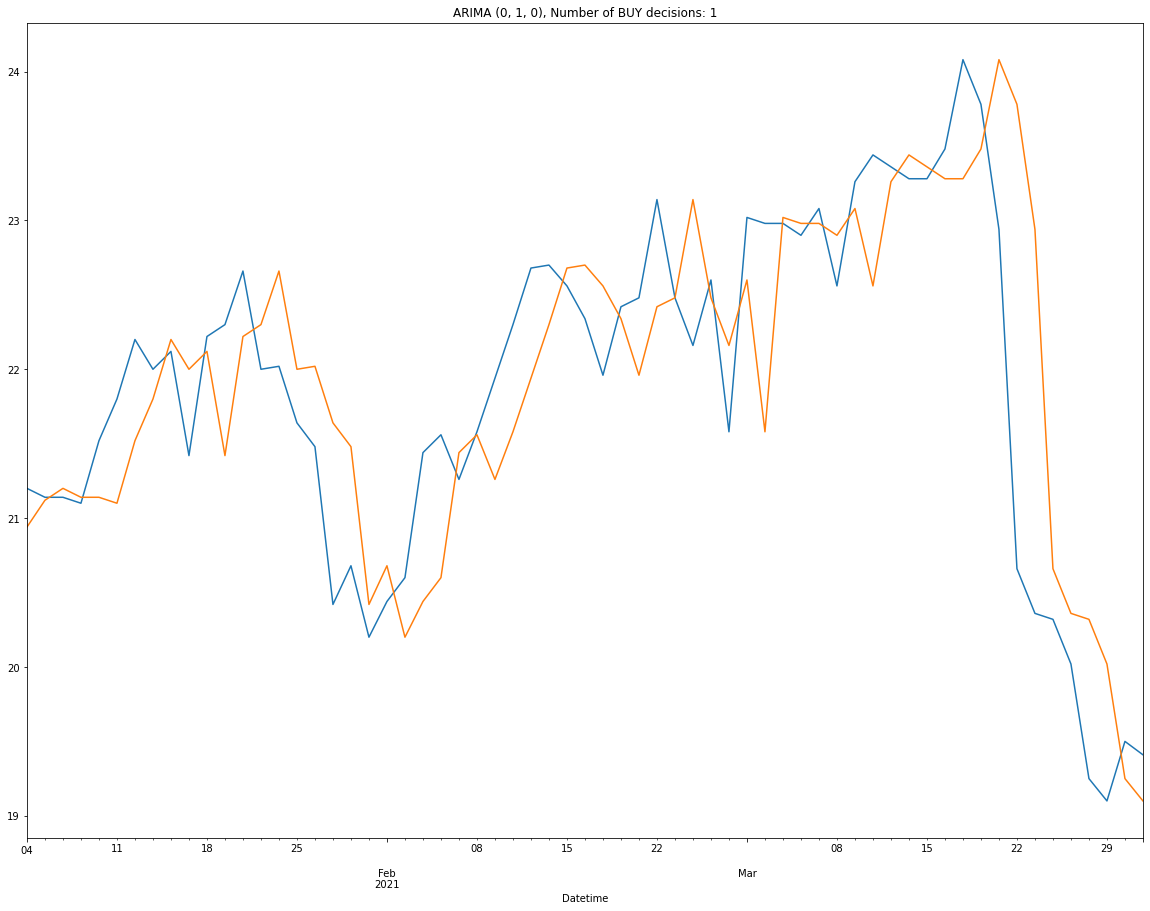

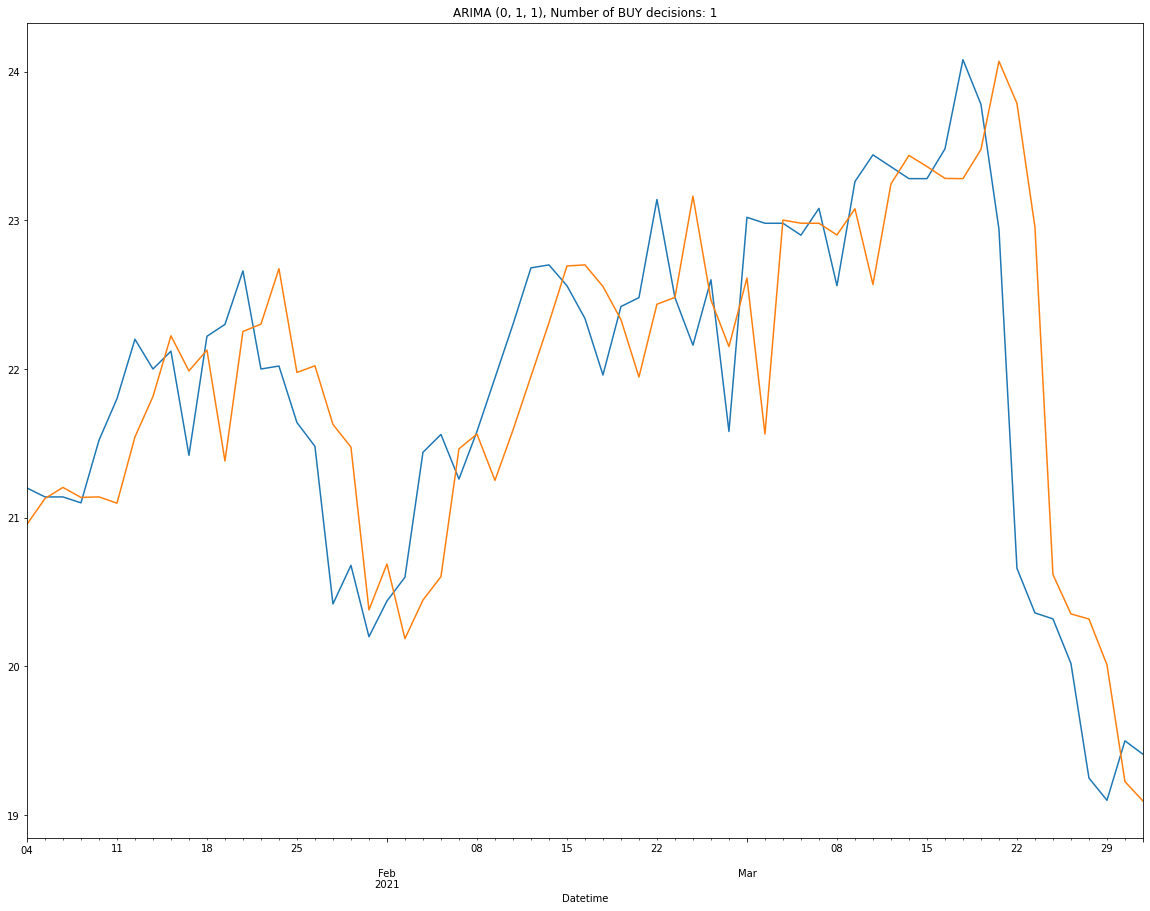

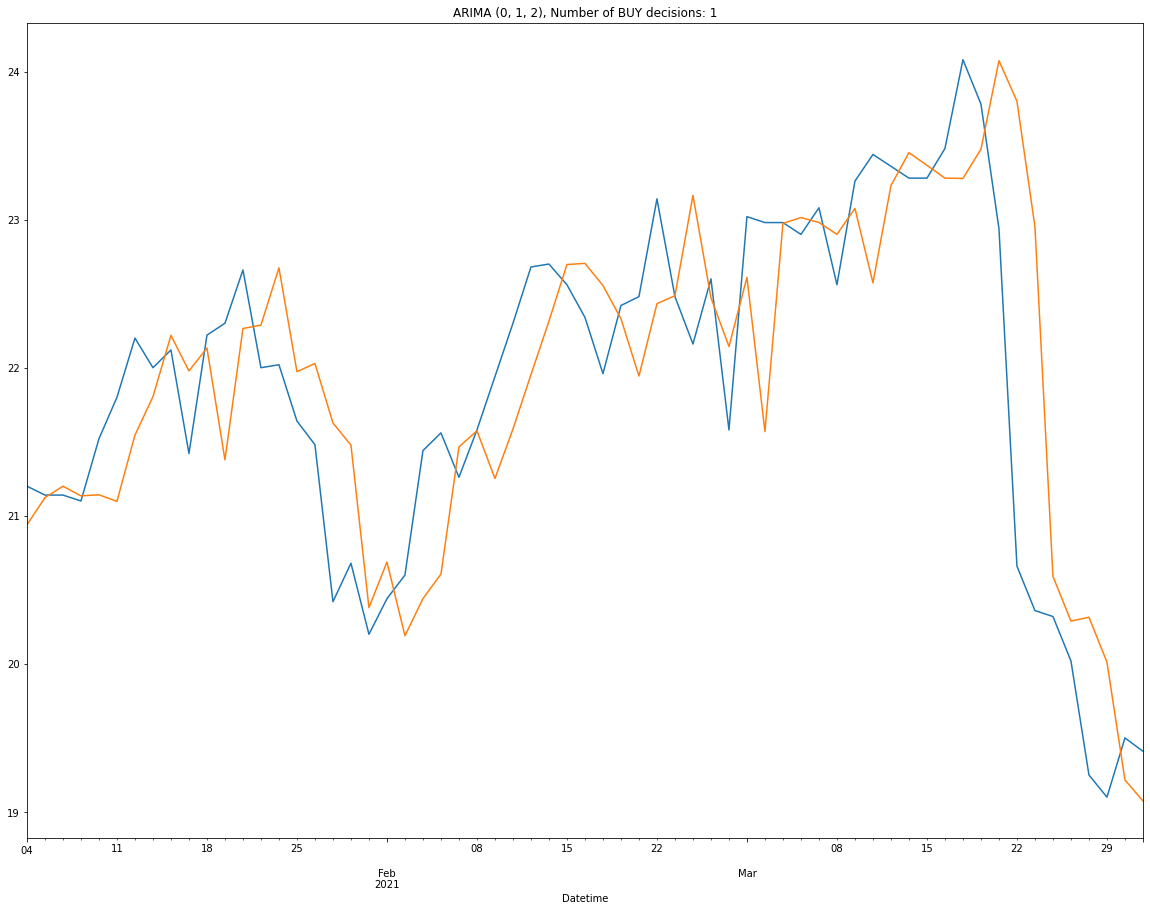

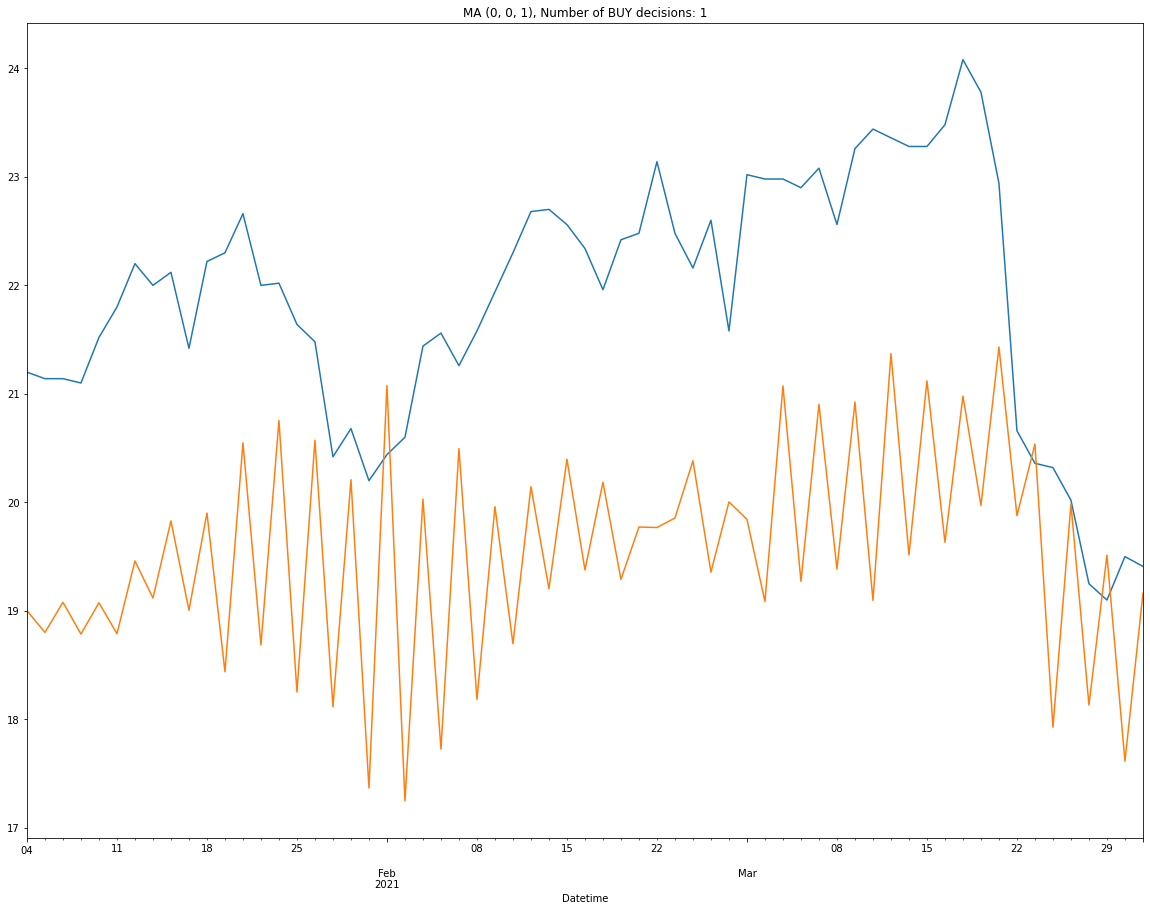

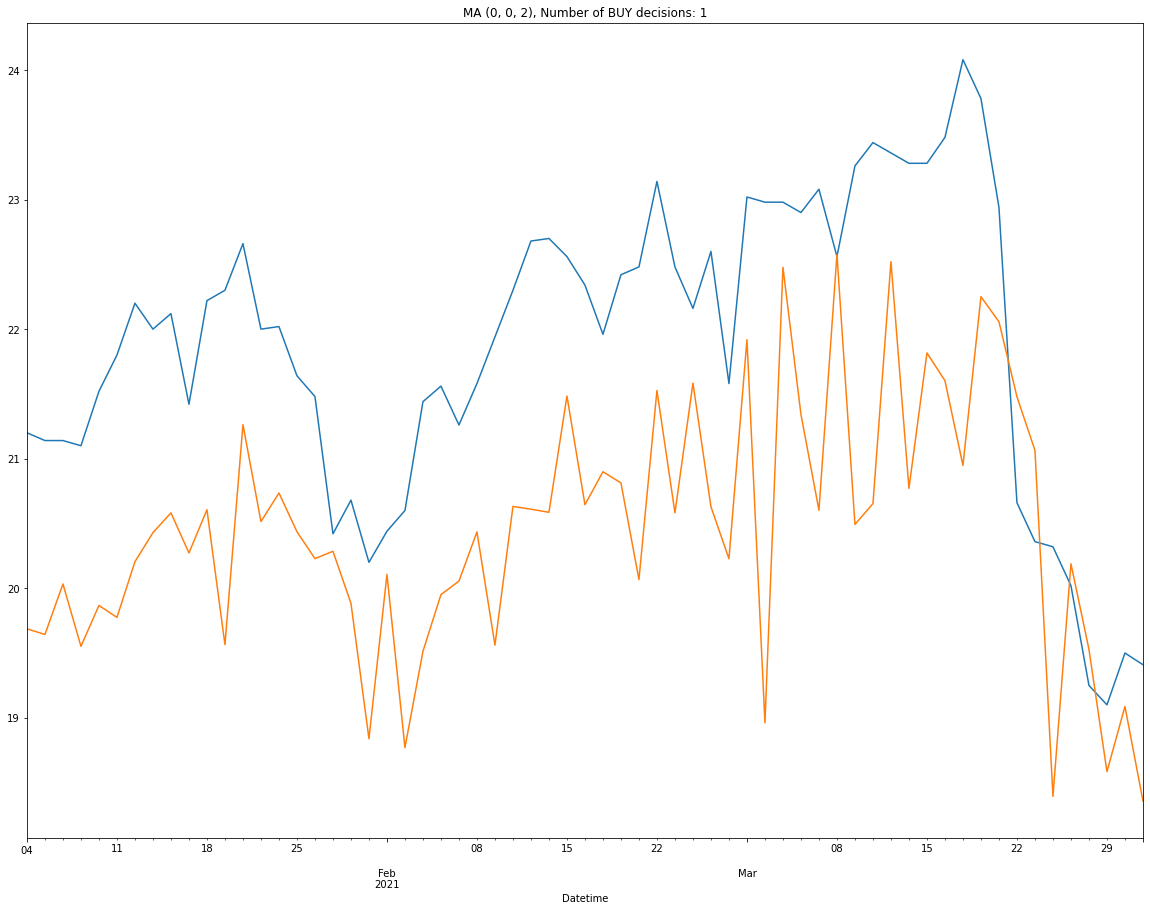

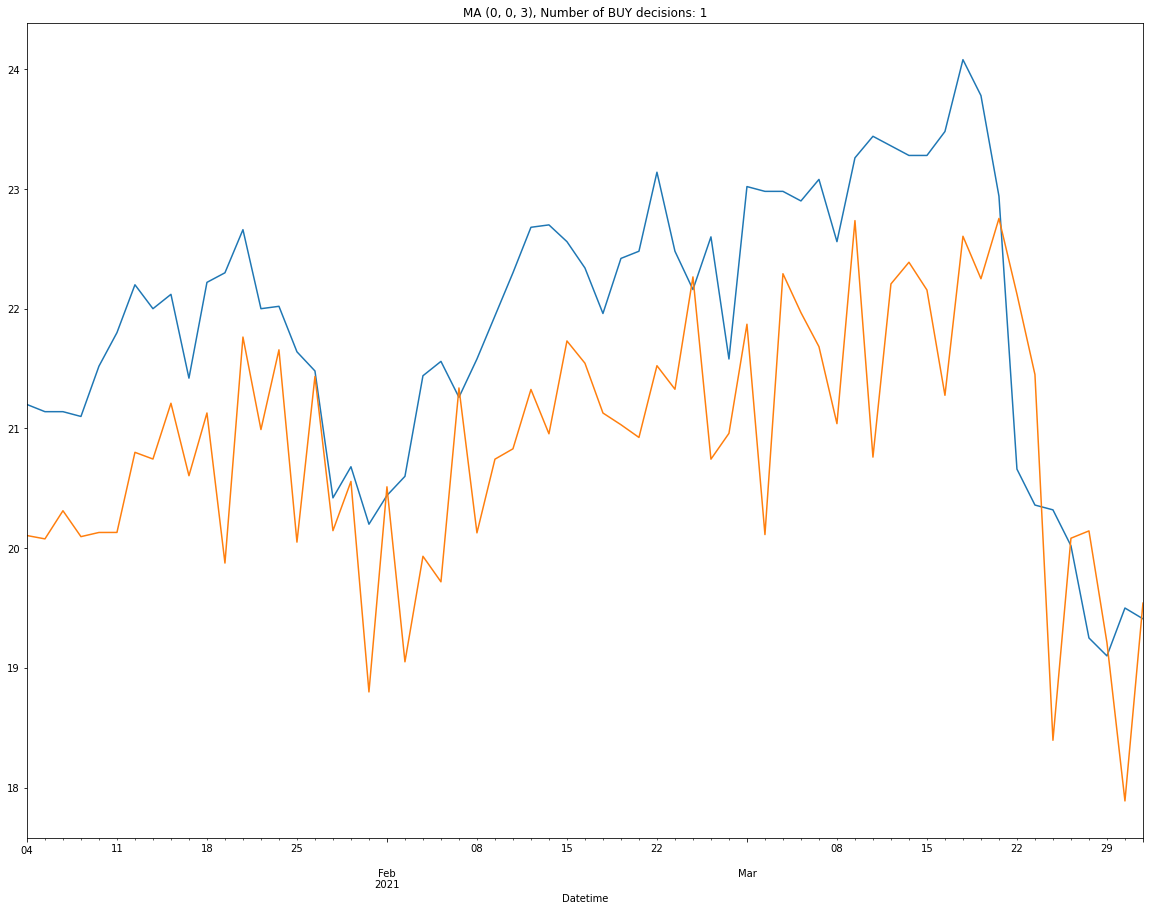

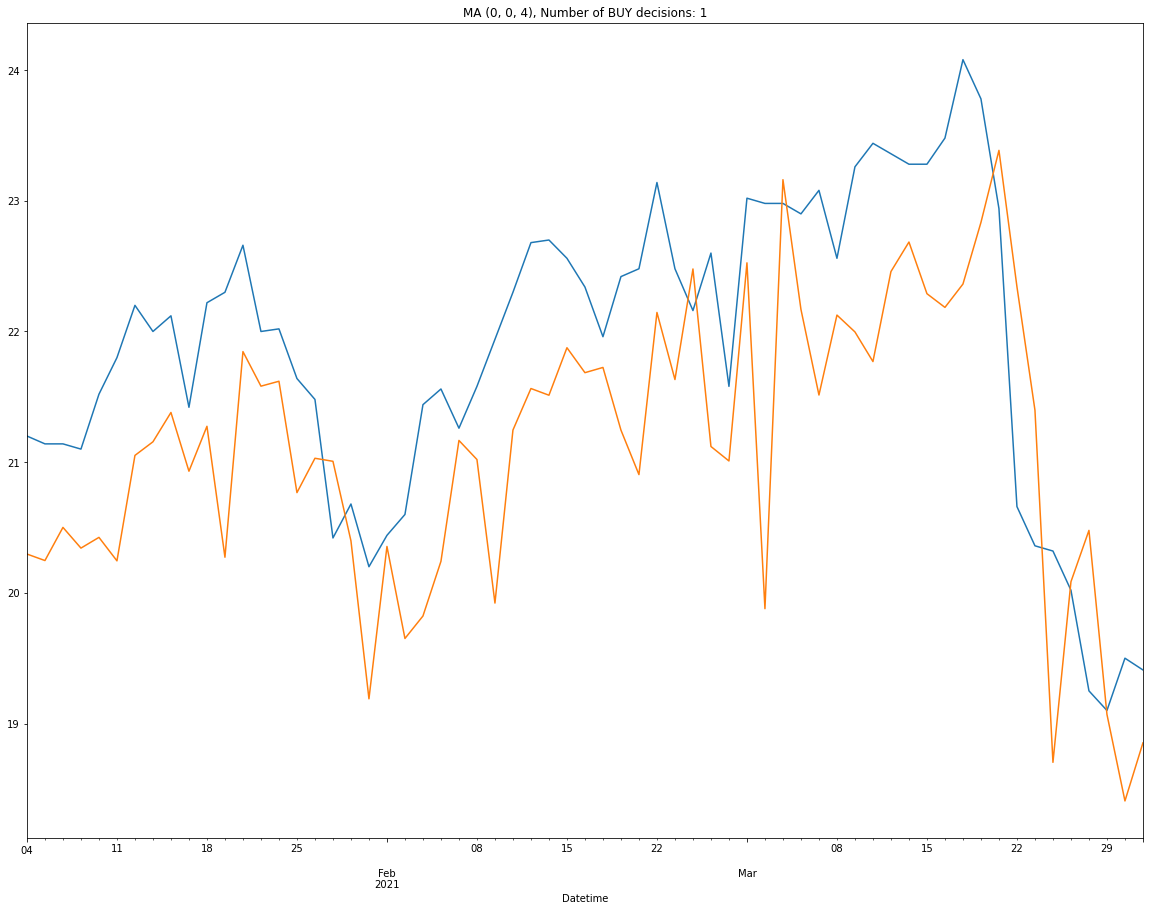

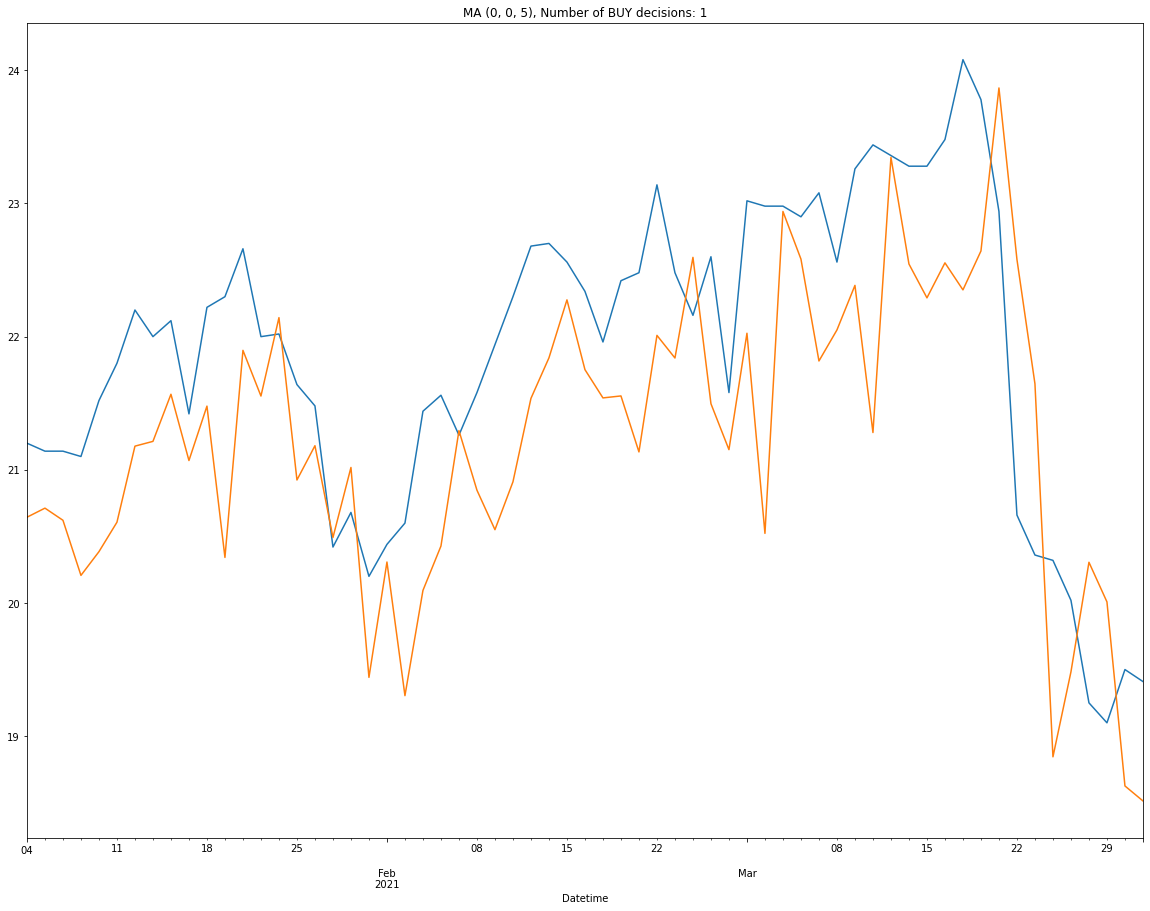

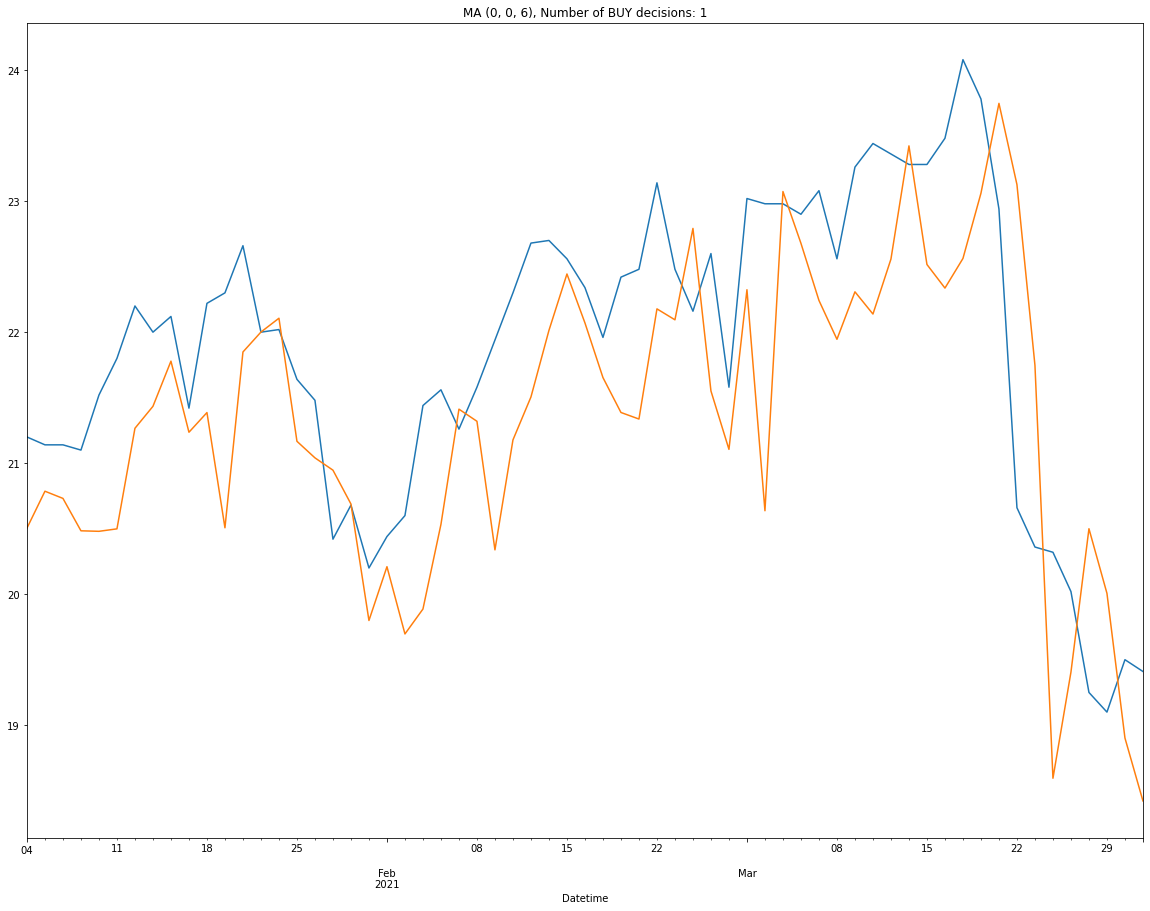

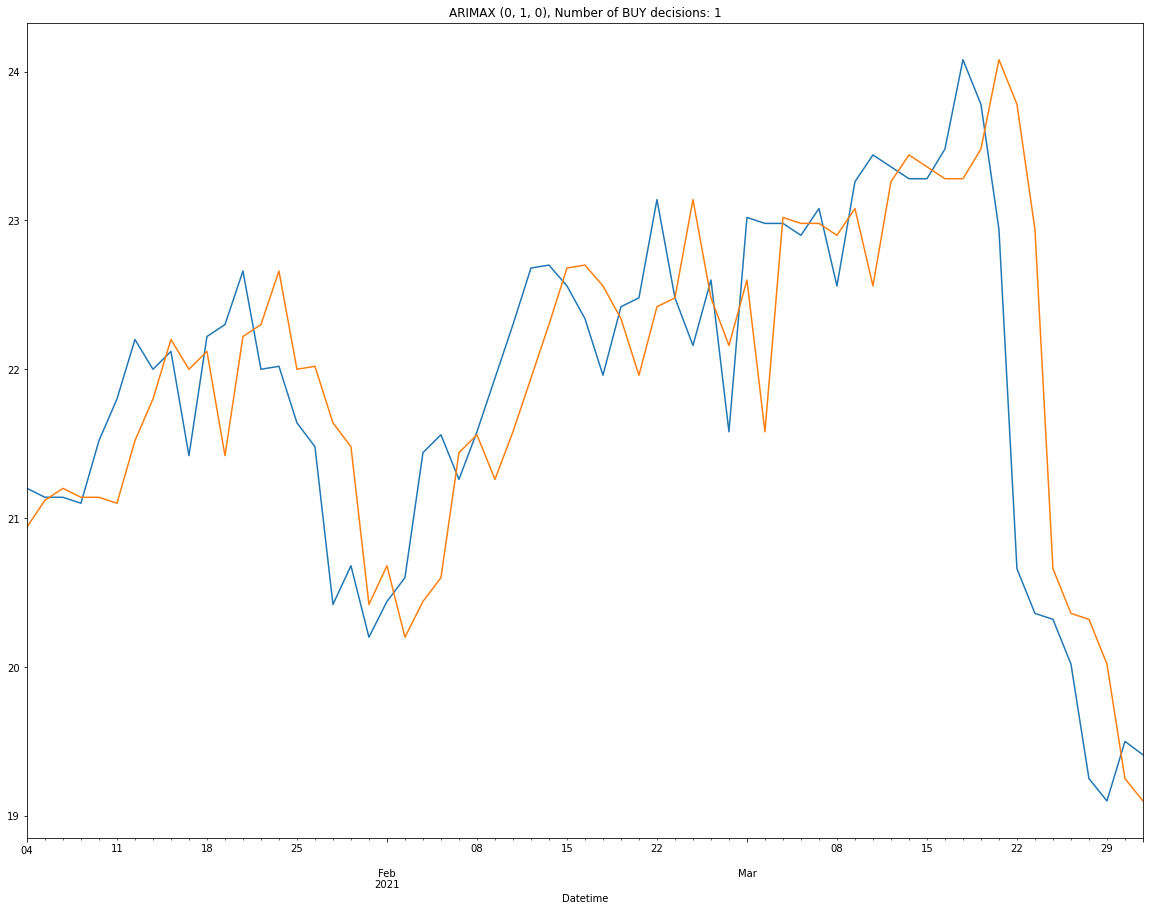

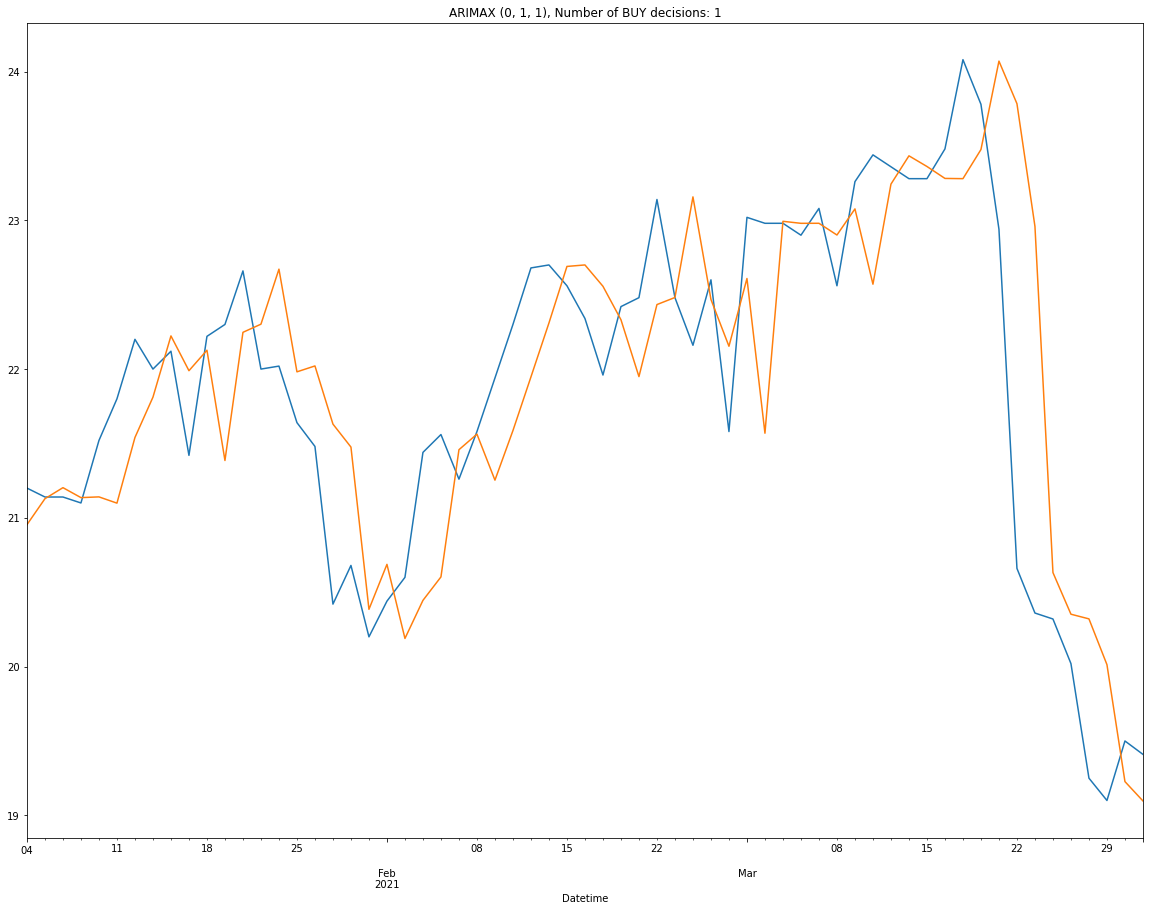

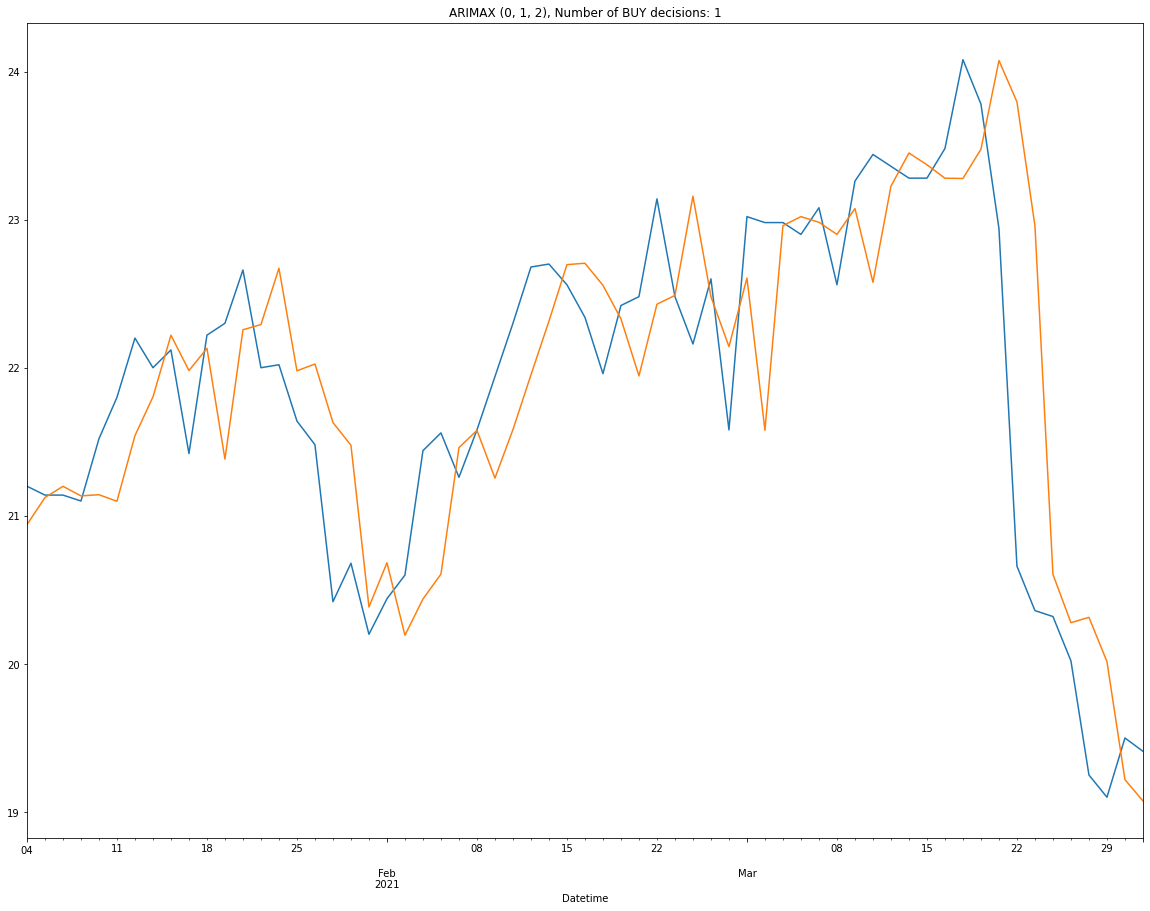

In [800]:
model_dict = {
    'ARIMA':[(0,1,0), (0,1,1), (0,1,2)], 
    'MA':[(0,0,1),(0,0,2),(0,0,3),(0,0,4),(0,0,5),(0,0,6)], 
    'ARIMAX':[(0,1,0), (0,1,1), (0,1,2)]
}

i=1
sheet = df[list(df.keys())[i]]
sheet = sheet.iloc[:-1,:] # Drop the last row
sheet["Predicted Price"] = predicted.predicted_mean
sheet["Decision"] = ""
sheet['Vol.'] = sheet['Vol.'].str[:-1].apply(pd.to_numeric, errors='coerce').fillna(0, downcast='infer')

# Convert dates to DateTime
sheet["Datetime"] = pd.to_datetime(sheet["Date"],format='%Y-%m-%d %H:%M:%S') 

# Set Datetime as the index
sheet = sheet.set_index(pd.DatetimeIndex(sheet["Datetime"])).sort_index()

# Run ARIMA models
for parameter_set in model_dict['ARIMA']:
    sheet_predictions = make_decisions_3(sheet, parameter_set)

    figure, axis = plt.subplots()
    axis.title.set_text(f"ARIMA {parameter_set}, Number of BUY decisions: {len(sheet_predictions[sheet_predictions['Decision'] == 'BUY'])}")
    axis = (sheet_predictions.Price).plot(label='observed', figsize=(20, 15))
    sheet_predictions['Predicted Price'].plot(ax=axis, label='forecast')

# Run MA models
for parameter_set in model_dict['MA']:
    sheet_predictions = make_decisions_3(sheet, parameter_set)

    figure, axis = plt.subplots()
    axis.title.set_text(f"MA {parameter_set}, Number of BUY decisions: {len(sheet_predictions[sheet_predictions['Decision'] == 'BUY'])}")
    axis = (sheet_predictions.Price).plot(label='observed', figsize=(20, 15))
    sheet_predictions['Predicted Price'].plot(ax=axis, label='forecast')

# Run ARIMAX models
for parameter_set in model_dict['ARIMAX']:
    sheet_predictions = make_decisions_3(sheet, parameter_set, arimax=True)

    figure, axis = plt.subplots()
    axis.title.set_text(f"ARIMAX {parameter_set}, Number of BUY decisions: {len(sheet_predictions[sheet_predictions['Decision'] == 'BUY'])}")
    axis = (sheet_predictions.Price).plot(label='observed', figsize=(20, 15))
    sheet_predictions['Predicted Price'].plot(ax=axis, label='forecast')
    

### Bollinger Bands
Use Bollinger Bands to measure your systems effectiveness.

/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



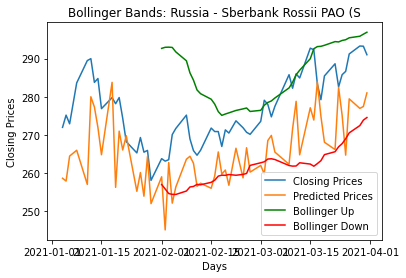

/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



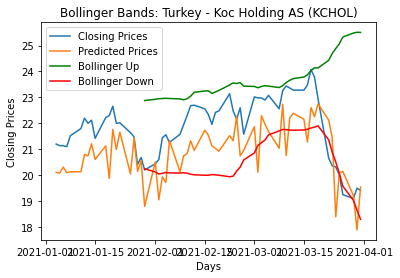

/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



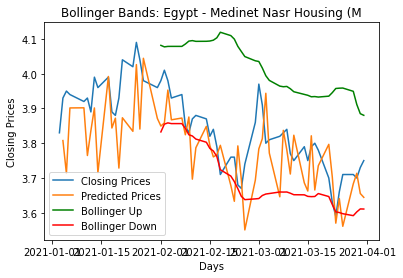

/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



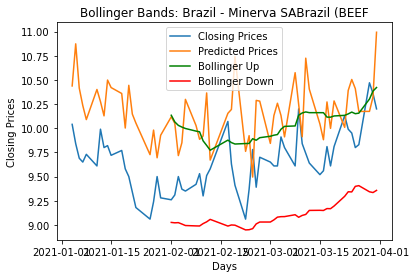

/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



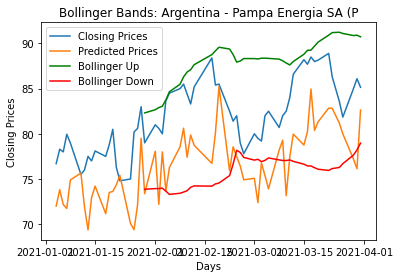

/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: Co

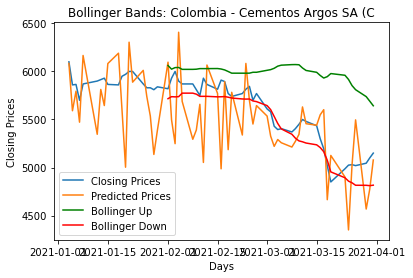

/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: Co

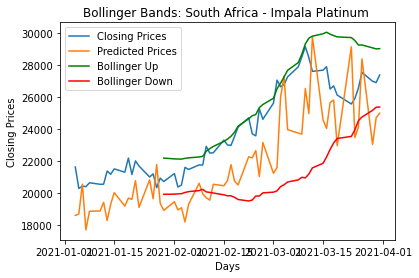

/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



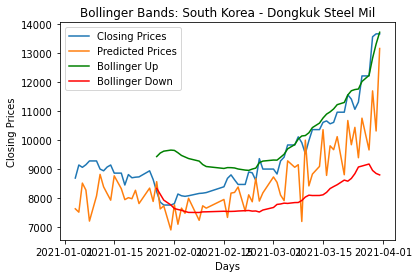

In [830]:
import pandas_datareader as pdr

def get_sma(prices, rate):
    return prices.rolling(rate).mean()

def get_bollinger_bands(prices, rate=20):
    sma = get_sma(prices, rate)
    std = prices.rolling(rate).std()
    bollinger_up = sma + std * 2 # Calculate top band
    bollinger_down = sma - std * 2 # Calculate bottom band
    return bollinger_up, bollinger_down

for i in range(0,len(list(df.keys()))):
    sheet = df[list(df.keys())[i]]
    sheet = sheet.iloc[:-1,:] # Drop the last row
    sheet["Predicted Price"] = predicted.predicted_mean
    sheet["Decision"] = ""
    sheet['Vol.'] = sheet['Vol.'].str[:-1].apply(pd.to_numeric, errors='coerce').fillna(0, downcast='infer')

    # Convert dates to DateTime
    sheet["Datetime"] = pd.to_datetime(sheet["Date"],format='%Y-%m-%d %H:%M:%S') 

    # Set Datetime as the index
    sheet = sheet.set_index(pd.DatetimeIndex(sheet["Datetime"])).sort_index()

    # Make predictions for MA (0, 0, 3)
    sheet_predictions = make_decisions_3(sheet, (0, 0, 3))
    closing_prices = sheet_predictions['Price']

    bollinger_up, bollinger_down = get_bollinger_bands(closing_prices)

    # New strategy
    plt.title('Bollinger Bands: ' + list(df.keys())[i])
    plt.xlabel('Days')
    plt.ylabel('Closing Prices')
    plt.plot(closing_prices, label='Closing Prices')
    plt.plot(sheet_predictions['Predicted Price'], label='Predicted Prices')
    plt.plot(bollinger_up, label='Bollinger Up', c='g')
    plt.plot(bollinger_down, label='Bollinger Down', c='r')
    plt.legend()
    plt.show()

## Summary

### Problem
The aim of this project was to use provided stock market data to make daily predictions that enable us to maximize our investment profits.

With a moving average model, we were able to achieve an overall net positive capital returns result across the 8 test sets.

### Approach
After loading and cleaning the data, we tested a few different approaches for modelling our training data (using 2020 Q1-Q2-Q3-Q4 stock prices):
- ARIMA (Autoregressive integrated moving average)
- SARIMAX (Seasonal Auto-Regressive Integrated Moving Average with eXogenous factors)
- SES (Simple Exponential Smoothing) Model
- HES (Holt's Exponential Smoothing) Model
- Simple Moving Average Model

For each of these models we needed to check assumptions (if any) and come up with an appropriate set of parameters.

After looking at the forecasted predictions that resulted from these models, we narrowed it down to a set of 3 models, each with a set of different parameters.

Based on the overall capital returns results, we selected the best model. 

### Challenges
One of the biggest challenges was the volatility of the training data. Due to the nature of the stock market during this period, prices did not follow a consistent trend. This resulted in ARIMA forecasts that would often be simple a constant number. Initially a training set of 2020 Q1-Q2-Q3 was used, with Q4 used for validation. We then later added Q4 to our training set to improve our model.

Another challenge was deciding on a strategy on how to recommend BUY, HOLD, and SELL decisions. In the end we decided that the most consistent results across the board would be gained by using all the prior data available. We could then make BUY/SELL decisions when the predicted price was significantly different from the recent average price. The downside of this approach is it can result in lengthy HOLD periods.

Given the volatility of the 2020 data, it may be worthwhile running the experiment with 2019 data to compare the results and assess whether these challenges remain.

### Results
The best overall model was a simple moving average model with parameters p=0, d=0, q=3. This does however vary a bit, with a maximum percentage profit on a dataset being almost 55% and a loss as large as 16%.